# Fraud Detection Project
This work consist into the implementation of a process of data mining to solve a fraud detection problem. The focus of the work is to implement different pre-processing e processing algorithm to compare them and decide which one is the best according to the used dataset. The chosen dataset has been taken from the Kaggle website and consists of a set of over 555.000 transactions made by european credit card in the 2023.

The dataset is made by 31 columns and the majority of them are anonymized for privacy reasons. The clear attributes are the id, the amount and the class, that is equal to 1 for positive fraudolent transaction and 0 for legal transactions. 

Now, the first think to do is to visually analyze the dataset into a Data Exploration process.

-----

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain,cycle
from statistics import mean
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from IPython.display import display_html

df = pd.read_csv('creditcard_2023.csv')
df = df.drop("id", axis=1)
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0


As a first thing to do it would be a good idea to remove the id column because it is just an identifier and a primary key of the transactions. This would obfuscate possible duplicated data. Then I would like to understand how many objects have null values, so that in case it is a low number we can remove them from the dataset and have a better Data Exploration later, with the actual tuples we will use in our dataset.

In [2]:
df.isna().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

As we can see above there are not null values for any of the variables. This is a great advantage because this permits us to avoid a first phase of Data Cleaning.

Now we can analyze the class distribution of the dataset, to understand how many fraudolent transaction we have compared to the legal transactions.

Class
0    284315
1    284315
Name: count, dtype: int64


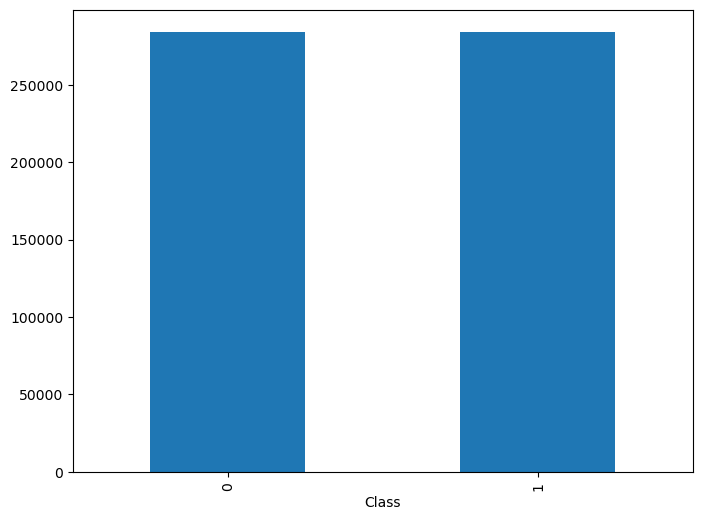

In [3]:
#Histogram about the class distribution
df_class = df['Class'].value_counts()
df_class.plot(kind='bar', figsize=(8,6), fontsize=10)
print(df_class)

As we can see the number of the fraudolent transactions is equal to the number of legal transactions. This would be an advantage into finding a well performed classifier during the data mining process. This means that there is not the necessity to balance the dataset.

Now we can try to understand if there is some categorical variable. In that case we should translate it into a numerical one. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      568630 non-null  float64
 1   V2      568630 non-null  float64
 2   V3      568630 non-null  float64
 3   V4      568630 non-null  float64
 4   V5      568630 non-null  float64
 5   V6      568630 non-null  float64
 6   V7      568630 non-null  float64
 7   V8      568630 non-null  float64
 8   V9      568630 non-null  float64
 9   V10     568630 non-null  float64
 10  V11     568630 non-null  float64
 11  V12     568630 non-null  float64
 12  V13     568630 non-null  float64
 13  V14     568630 non-null  float64
 14  V15     568630 non-null  float64
 15  V16     568630 non-null  float64
 16  V17     568630 non-null  float64
 17  V18     568630 non-null  float64
 18  V19     568630 non-null  float64
 19  V20     568630 non-null  float64
 20  V21     568630 non-null  float64
 21  V22     56

Fortunately all the attribute are numerical variables, so there is not the need to translate any of the attributes. The statistical description of the amount attribute is the following.

In [5]:
df.Amount.describe()

count    568630.000000
mean      12041.957635
std        6919.644449
min          50.010000
25%        6054.892500
50%       12030.150000
75%       18036.330000
max       24039.930000
Name: Amount, dtype: float64

We can also take a look at all the variables, to understand if it can be a good idea to implement a Scaling operation in the Data Transformation phase.

In [6]:
df.describe(include="all")

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,1.991314e-16,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,-3.163276e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,-5.901008e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,2.626145e-01,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,5.924603e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,3.172271e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


It would be interesting to understand the density of fraudolent trasactions and legal transactions related to the Amount attribute (it's the only one we know). For this reason I will show three histograms:
1. Histogram of the density of transactions related to the amount;
2. Histogram of the density of legal transactions related to the amount;
3. Histogram of the density of fraudolent transactions related to the amount.

/tmp/ipykernel_86120/2801920528.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_amount = df_amount.groupby(pd.cut(df_amount, bins)).count()


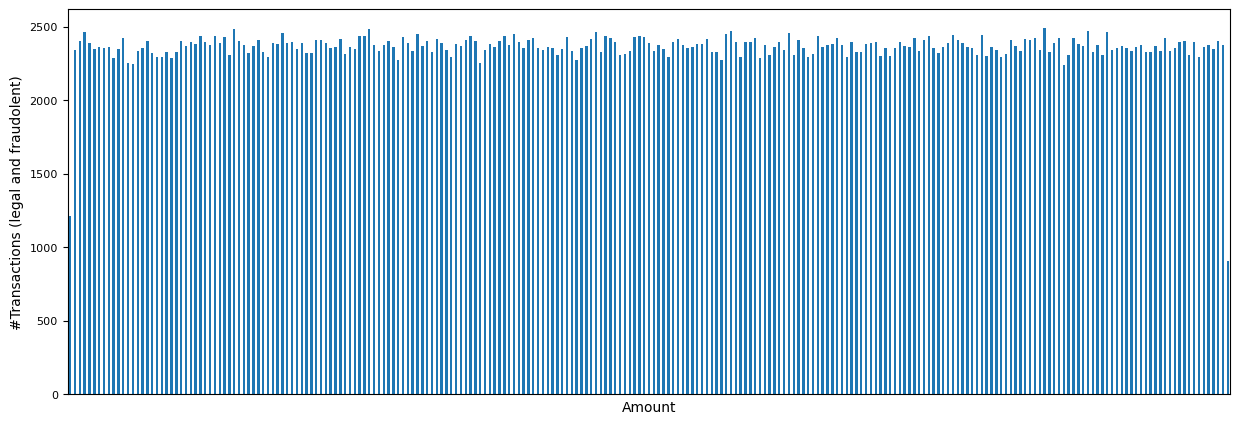

In [7]:
#Plot number of transactions according to the amount ranges

bins = np.arange(start = 0, stop = 24200, step = 100)

df_amount = df['Amount'].astype(int)
df_amount = df_amount.groupby(pd.cut(df_amount, bins)).count()
plot = df_amount.plot(kind='bar', figsize=(15,5), fontsize=8)
plot.set(xlabel="Amount", ylabel="#Transactions (legal and fraudolent)")
plt.xticks([])
plt.show()

/tmp/ipykernel_86120/480694592.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_legal_amount = df_legal_amount.groupby(pd.cut(df_legal_amount, bins)).count()


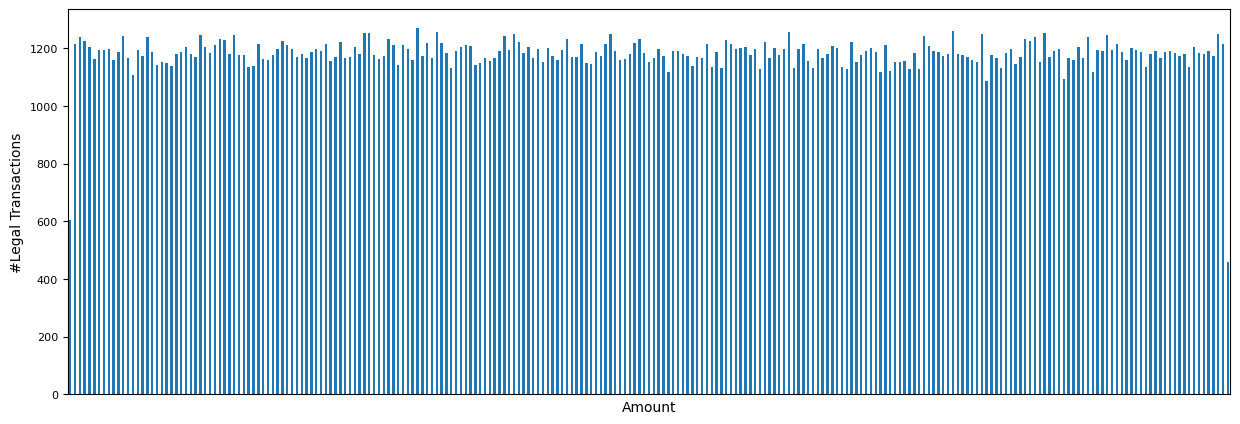

In [8]:
#Plot number of total transactions according to the amount ranges

bins = np.arange(start = 0, stop = 24200, step = 100)

df_legal = df.loc[df["Class"]== 0]
df_legal_amount = df_legal['Amount'].astype(int)
df_legal_amount = df_legal_amount.groupby(pd.cut(df_legal_amount, bins)).count()
plot = df_legal_amount.plot(kind='bar', figsize=(15,5), fontsize=8)
plot.set(xlabel="Amount", ylabel="#Legal Transactions")
plt.xticks([])
plt.show()

/tmp/ipykernel_86120/4071486843.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fraud_amount = df_fraud_amount.groupby(pd.cut(df_fraud_amount, bins)).count()


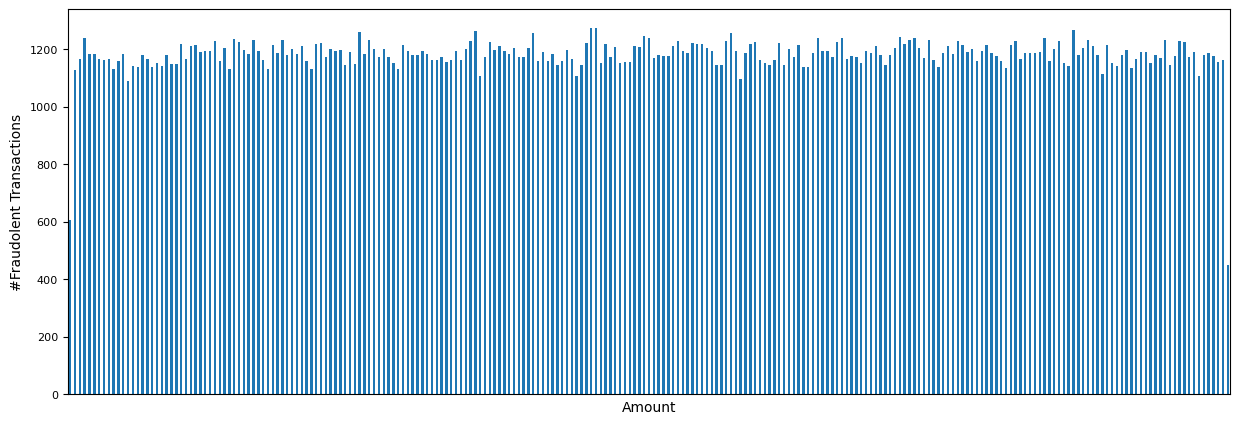

In [9]:
#Plot number of total transactions according to the amount ranges

bins = np.arange(start = 0, stop = 24200, step = 100)

df_fraudolent = df.loc[df["Class"]== 1]
df_fraud_amount = df_fraudolent['Amount'].astype(int)
df_fraud_amount = df_fraud_amount.groupby(pd.cut(df_fraud_amount, bins)).count()
plot = df_fraud_amount.plot(kind='bar', figsize=(15,5), fontsize=8)
plot.set(xlabel="Amount", ylabel="#Fraudolent Transactions")
plt.xticks([])
plt.show()

The distribution is omogeneous between the two classes so we aspect that the attribute amount wouldn't be that important for class prediction of a classifier. In the Data Transformation phase we will focus on the other variables to understand if there is correlation between the variables, to try to reduce dimensionality.


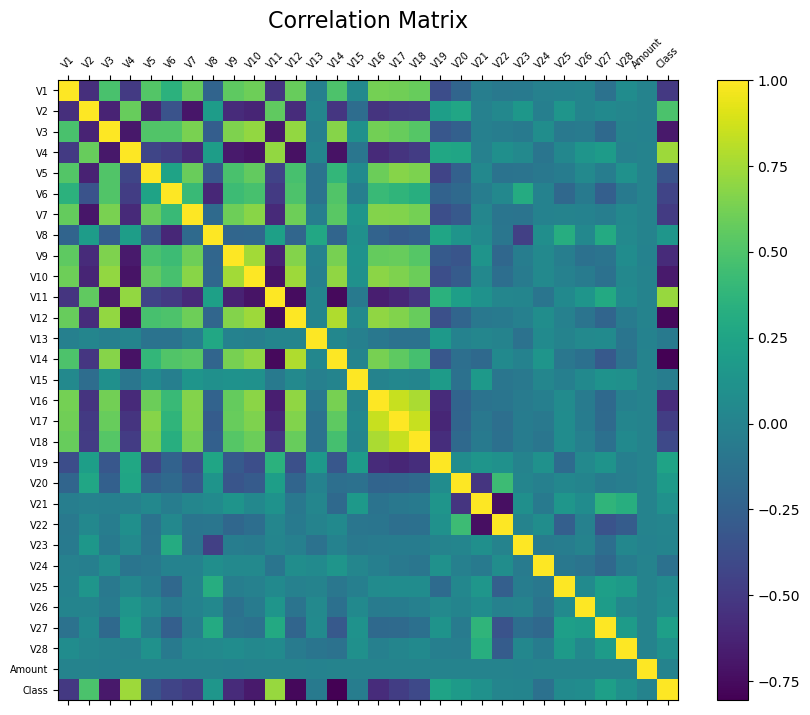

In [10]:
#Check features correlation
f = plt.figure(figsize=(10, 8))
plt.matshow(df.corr(), fignum = f. number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize = 7, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize = 7)
plt.title('Correlation Matrix', fontsize = 16);
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 10)
plt.show()

The correlation matrix is interesting because it shows an high correlation between some variables. Moreover it's important to focus on the correlation that involve the class we want to predict with our classification model. The matrix suggests, for example, that the class has a low correlation with the Amount, as we suspected before.

-----

# Pre-processing phase

The pre-processing phase implemented consists of Data Cleaning, Data Transformation and the division of the dataset into trainset and testset. 

### Data Cleaning

The Data Cleaning phase involves:
1. Eliminate the rows that contain NaN values;
2. Drop duplicate transactions.

The first step is not necessary because, as we saw before, there not exist tuples with NaN values. This means that the only think we are going to do is to eliminate the duplicate transactions.

In [11]:
df_class = df['Class'].value_counts()
print(df_class)

Class
0    284315
1    284315
Name: count, dtype: int64


In [12]:
#Drop duplicates
df.drop_duplicates(inplace = True)
df_class = df['Class'].value_counts()
print(df_class)

Class
0    284315
1    284314
Name: count, dtype: int64


We obtained that there was just one duplicate transaction.

.

### Data Transformation

The Data Transformation phase implemented consists of a Feature Selection operation and a Normalization of the dataset. The feature selection phase is aimed at a reduction of the dimensionality of the dataset to have a better performance of the classifier and a faster training phase. The Normalization would improve the performance of the training phase, resulting in better statistics with the method obtained.

To understand the power of these adjustments, at the end of this phase we will have four different datasets to use during the processing phase. Once we have obtained the methods from each of the dataset we will compare the statistics. The datasets we are going to create are:

1. MinMax Scaled Dataset: the dataset after a MinMax Scaling operation on it;
2. Z-score Scaled Dataset: the dataset after a Z-score Scaling operation on it;
3. Selected Feature MinMax Normalized Dataset: the dataset after MinMax Scaling and feature selection;
4. Selected Feature Z-score Normalized Dataset: the dataset after Z-score Scaling and feature selection.

We already have the basic dataset, so we are going to create the MinMax Scaled Dataset and the Z-store Scaled Dataset.

.

### MinMax Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

columns = df.keys()
array_columns = np.array(columns)

indexes = list(set(range(29)))
numeric_columns = array_columns[indexes].tolist()

df_mms = df.copy()
minmax_scaler = MinMaxScaler().fit(df_mms[numeric_columns])
df_mms[numeric_columns] = minmax_scaler.transform(df_mms[numeric_columns])

df_mms.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.705598,0.379766,0.488612,0.238820,0.482134,0.593994,0.084851,0.335668,0.499874,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.036402,0.049097,0.016128,0.058708,0.035418,0.072201,0.008082,0.008599,0.288439,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.699540,0.355683,0.484780,0.200568,0.462507,0.548371,0.082387,0.333674,0.250307,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.704236,0.378424,0.487649,0.239754,0.481844,0.593136,0.083454,0.335548,0.499381,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.710986,0.402541,0.491123,0.279959,0.501614,0.642577,0.087551,0.339190,0.749745,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see on the table above, the values have been normalized into an interval [0,1]. This is important because the attributes will have all the same weight (in terms of scale) during the processing operations.

.

### Z-score Scaling

Now we are going the create the Z-score Scaled Dataset:

In [14]:
from sklearn.preprocessing import StandardScaler

columns = df.keys()
array_columns = np.array(columns)

indexes = list(set(range(29)))
numeric_columns = array_columns[indexes].tolist()

df_zs = df.copy()
z_score_scaler = StandardScaler().fit(df_zs[numeric_columns])
df_zs[numeric_columns] = z_score_scaler.transform(df_zs[numeric_columns])

df_zs.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-5.348167e-17,-5.223210e-18,1.028710e-17,-5.298184e-18,-6.847653e-18,1.524478e-17,8.397122e-18,-7.197533e-18,-1.422138e-16,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-1.938361e+01,-7.735086e+00,-3.029648e+01,-4.067970e+00,-1.361262e+01,-8.226963e+00,-1.049864e+01,-3.903536e+01,-1.733030e+00,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-1.664365e-01,-4.905153e-01,-2.376262e-01,-6.515818e-01,-5.541480e-01,-6.318948e-01,-3.049585e-01,-2.318753e-01,-8.652311e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,-3.741858e-02,-2.733978e-02,-5.968015e-02,1.590069e-02,-8.193326e-03,-1.189111e-02,-1.729089e-01,-1.392600e-02,-1.706617e-03,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,1.479986e-01,4.638922e-01,1.557313e-01,7.007386e-01,5.500151e-01,6.728875e-01,3.340244e-01,4.095939e-01,8.662877e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,8.087552e+00,1.263295e+01,3.170873e+01,1.296564e+01,1.462150e+01,5.623280e+00,1.132312e+02,7.725619e+01,1.733906e+00,1.000000


As we can observe comparing the obtained dataset with the original one, the original dataset was already z-score normalized, even though it was not reported into the dataset description. This last scaling operation is a little bit better than the original one due to the fact that we removed a tuple as a duplicate from the dataset, so now is perfectly z-score scaled.

In conclusion, we will only use the minmax scaled dataset and the z-score scaled dataset.

.

### Feature Selection

We can now proceed to a feature selection phase, involving the Heuristic Approach seen during the course, based on Mutual Information and Information Gain. We are going to obtain the last two datasets, the ones with the selected features.

.

#### Feature Selection on Basic Dataset

In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X.shape


selector = SelectKBest(mutual_info_classif, k=20)
X_new = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
X_new_columns = X.iloc[:,cols].columns.tolist()
X_new_columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V21',
 'V27',
 'V28']

In [16]:
column_names = list(df)
df_reduced = df.copy()

#Here we make a manual reduction of the Dataframe, considering the features provided by the Feature Selection process.
for a in column_names:
    if a not in X_new_columns and a != "Class":
        df_reduced = df_reduced.drop(a, axis=1)

df_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,568629.000000,568629.000000,568629.000000,5.686290e+05,568629.000000,568629.000000,568629.000000,568629.000000,5.686290e+05,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,5.686290e+05,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.000003,-0.000005,0.000002,-8.855104e-07,0.000002,-0.000006,0.000004,0.000011,-4.807863e-07,0.000001,...,0.000001,0.000002,0.000002,0.000001,0.000002,2.989575e-07,-0.000014,-0.000003,-0.000004,0.499999
std,0.999999,0.999996,1.000000,1.000002e+00,1.000001,0.999993,0.999997,0.999970,1.000002e+00,1.000001,...,1.000001,1.000001,1.000000,1.000001,1.000001,1.000002e+00,0.999944,1.000000,0.999998,0.500000
min,-3.495584,-49.966572,-3.183760,-4.951222e+00,-9.952786,-21.111108,-4.351839,-10.756342,-3.751919e+00,-3.163276,...,-2.020399,-2.107417,-2.214513,-2.484938,-2.421949,-7.804988e+00,-19.382523,-10.498633,-39.035243,0.000000
25%,-0.565285,-0.486680,-0.649298,-6.560208e-01,-0.293495,-0.445872,-0.283533,-0.192257,-5.687501e-01,-0.590101,...,-0.831134,-0.873204,-0.716260,-0.619484,-0.556037,-5.653083e-01,-0.166441,-0.304961,-0.231878,0.000000
50%,-0.093636,-0.135894,0.000354,-7.376398e-02,0.081089,0.078716,0.233367,-0.114523,9.252585e-02,0.262617,...,0.162052,0.230502,0.134027,0.271641,0.087296,-2.597774e-02,-0.037431,-0.172911,-0.013930,0.000000
75%,0.832658,0.343553,0.628539,7.070060e-01,0.439738,0.497788,0.525955,0.047299,5.592661e-01,0.592462,...,0.744672,0.751822,0.655607,0.518225,0.544389,5.601185e-01,0.147976,0.334021,0.409589,1.000000
max,2.229046,4.361865,14.125834,3.201536e+00,42.716891,26.168402,217.873038,5.958040,2.027006e+01,31.722709,...,17.913556,19.169544,46.652906,6.994124,6.783716,3.831672e+00,8.087080,113.231093,77.255937,1.000000


The fact that the Amount attribute is not been selected is a demonstration of what we observed during the Data Exploration phase, that there is a low mutual information between the Amount and the Class to predict.

Now that we have the original dataset with selected features, we will do the same steps on the minmax scaled dataset and with the z-score scaled dataset.

.

#### Feature Selection on MinMax Scaled Dataset

In [17]:
column_names = list(df_mms)
df_mms_reduced = df_mms.copy()

#Here we make a manual reduction of the Dataframe, considering the features provided by the Feature Selection process.
for a in column_names:
    if a not in X_new_columns and a != "Class":
        df_mms_reduced = df_mms_reduced.drop(a, axis=1)

df_mms_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.101355,0.099047,0.045317,0.262150,0.263093,0.670724,0.705598,0.084851,0.335668,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.050166,0.046999,0.020464,0.105496,0.108629,0.085935,0.036402,0.008082,0.008599,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.059660,0.058007,0.030660,0.196797,0.202692,0.622144,0.699540,0.082387,0.333674,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.109484,0.109880,0.048059,0.290807,0.272576,0.668492,0.704236,0.083454,0.335548,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.138712,0.134382,0.058733,0.316821,0.322230,0.718858,0.710986,0.087551,0.339190,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


.

#### Feature Selection on Z-score Scaled Dataset

In [18]:
column_names = list(df)
df_zs_reduced = df_zs.copy()

#Here we make a manual reduction of the Dataframe, considering the features provided by the Feature Selection process.
for a in column_names:
    if a not in X_new_columns and a != "Class":
        df_zs_reduced = df_zs_reduced.drop(a, axis=1)

df_zs_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-2.007312e-16,6.077917e-17,-2.639096e-17,1.167600e-16,2.479150e-17,-9.976581e-17,-5.348167e-17,8.397122e-18,-7.197533e-18,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-2.020400e+00,-2.107420e+00,-2.214516e+00,-2.484939e+00,-2.421950e+00,-7.804982e+00,-1.938361e+01,-1.049864e+01,-3.903536e+01,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-8.311350e-01,-8.732063e-01,-7.162625e-01,-6.194854e-01,-5.560383e-01,-5.653081e-01,-1.664365e-01,-3.049585e-01,-2.318753e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,1.620507e-01,2.304996e-01,1.340253e-01,2.716395e-01,8.729456e-02,-2.597802e-02,-3.741858e-02,-1.729089e-01,-1.392600e-02,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,7.446707e-01,7.518204e-01,6.556051e-01,5.182237e-01,5.443876e-01,5.601177e-01,1.479986e-01,3.340244e-01,4.095939e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,1.791355e+01,1.916955e+01,4.665293e+01,6.994120e+00,6.783714e+00,3.831668e+00,8.087552e+00,1.132312e+02,7.725619e+01,1.000000


Now we obtained all the datasets we'd like to test. The variables that contain the datasets are:

1. MinMax Scaled Dataset: df_mms;
2. Z-score Scaled Dataset: df_zs;
3. Reduced MinMax Scaled Dataset: df_mms_reduced;
4. Reduced Z-score Scaled Dataset: df_zs_reduced.

.

## Dataset Split: Cross-Validation

The approach used for the splitting procedure into training set and test set is a 5-fold cross-validation. This means that the dataset used is divided into 5 folds and for each turn 1 of the folds is used as testset and the other ones as training set. The turn that provides the best statistics is the chosen one as the final classification method.

In [19]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

Now that we have obtained the datasets, we can continue to the processing phase.

-----



# Data Mining

The aim of this phase is to implement different classifier and compare their statistics to understand which is the best for our dataset. The classification algorithms I tried are:

1. Logistic Regression;
2. Neural Network;
3. Random Forest.

For each of the classifier algorithm chosen I created an estimator with each of the database we obtained in the pre-processing phase. 


## Logistic Regression

The Logistic Regression algorithm is based on the convergence to a continue valued solution. Depending on the value obtained, the classifier set the prediction. The max iteration we set for the algorithm is equal to 1000 steps. The advantage of this approach is a good training in a relative reduced fit-time compared to other Machine Learning algorithms.

The Logistic Regression function we will use during the training phase is the following:

In [20]:
def kfoldLogisticRegression(target, data):
    df_target = target
    df_data = data

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
    logreg = LogisticRegression(max_iter = 1000, random_state = 0)
    
    fit_time = []
    round_acc = []
    round_auc = []
    round_prec = []
    round_rec = []
    round_f1s = []
    
    k = 1
    for train, test in skf.split(np.zeros(len(df_target)), df_target):
        print(f'\n\n\n*****************************************************')
        print(f'FOLD {k}')
        
        # Classifier operations
        X_tr = df_data.iloc[train]
        y_tr = df_target.iloc[train]
        X_te = df_data.iloc[test]
        y_te = df_target.iloc[test]
        
        start = time.time()
        logreg.fit(X_tr,y_tr)
        end = time.time()
        
        fit_time.append(str(round(end-start, 2)))
        
        y_pred = logreg.predict(X_te)
        
        
        print("----------- CLASSIFICATION REPORT --------------\n")
        cr = classification_report(y_te, y_pred, output_dict = True)
        print(classification_report(y_te, y_pred))
        
        round_acc.append(cr['accuracy'])
        round_prec.append(cr['macro avg']['precision'])
        round_rec.append(cr['macro avg']['recall'])
        round_f1s.append(cr['macro avg']['f1-score'])
        round_auc.append(roc_auc_score(y_pred, y_te))
        
        print("--------------CONFUSION MATRIX--------------\n")
        ConfusionMatrixDisplay.from_predictions(y_te, y_pred, display_labels = ['legal','fraudulent'])
        plt.show()

        k=k+1

    
        
    print("\n\n\n ---------------------------------------------\n --------------- GENERAL STATISTICS --------------- \n")

    print("Accuracy per round: ")
    print(round_acc)

    print("Precision per round: ")
    print(round_prec)

    print("Recall per round: ")
    print(round_rec)

    print("F1-score per round: ")
    print(round_f1s)

    print("AUC per round: ")
    print(round_auc)
    
    print("Fit_time per round: ")
    print(fit_time)
        
    avg_acc = np.mean(round_acc)
    print("The average accuracy is: ", avg_acc)

    avg_prec = np.mean(round_prec)
    print("The average precision is: ", avg_prec)

    avg_rec = np.mean(round_rec)
    print("The average recall is: ", avg_rec)

    avg_f1s = np.mean(round_f1s)
    print("The average F1-score is: ", avg_f1s)

    avg_auc = np.mean(round_auc)
    print("The average AUC is: ", avg_auc)
        
    fit_time = [float(i) for i in fit_time]
        
    avg_fit_time = np.mean(fit_time)
    print("The average fit-time is: ", avg_fit_time, "seconds\n\n")

    rounds = ["Round1", "Round2", "Round3", "Round4", "Round5"]
    fig, ax = plt.subplots()
    plot = plt.bar(rounds, fit_time)
    ax.bar_label(plot)
    plt.xticks(np.arange(5), ['Round1', 'Round2', 'Round3', 'Round4', 'Round5'], rotation = 'vertical')
    plt.title('Fit Times of Logistic Regression Basic Database', fontsize = 16);
    plt.ylabel("Time(sec)")
    plt.show()

    print("\n\n------------------------------------------------------------\n\n")

    return (round_acc, avg_acc, avg_fit_time)


.

### Logistic Regression on MinMax Scaled Dataset

In [21]:
df_mms.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.705598,0.379766,0.488612,0.238820,0.482134,0.593994,0.084851,0.335668,0.499874,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.036402,0.049097,0.016128,0.058708,0.035418,0.072201,0.008082,0.008599,0.288439,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.699540,0.355683,0.484780,0.200568,0.462507,0.548371,0.082387,0.333674,0.250307,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.704236,0.378424,0.487649,0.239754,0.481844,0.593136,0.083454,0.335548,0.499381,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.710986,0.402541,0.491123,0.279959,0.501614,0.642577,0.087551,0.339190,0.749745,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





*****************************************************
FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



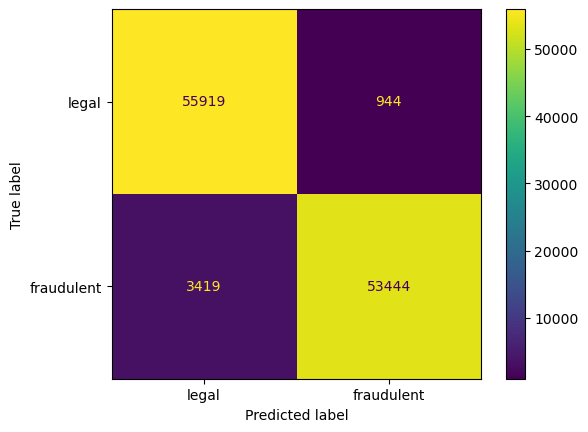




*****************************************************
FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



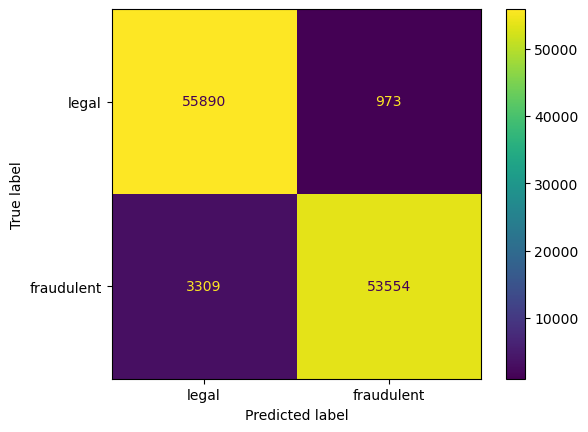




*****************************************************
FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



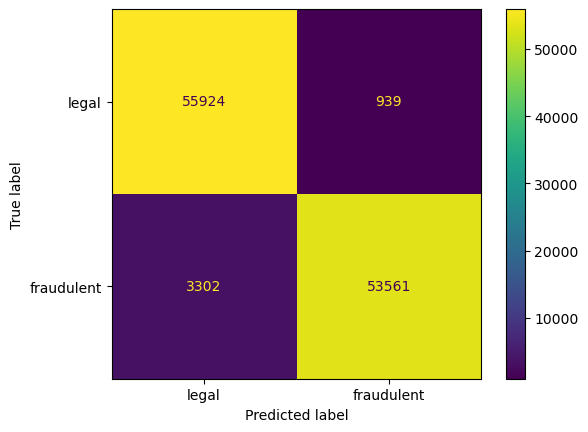




*****************************************************
FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



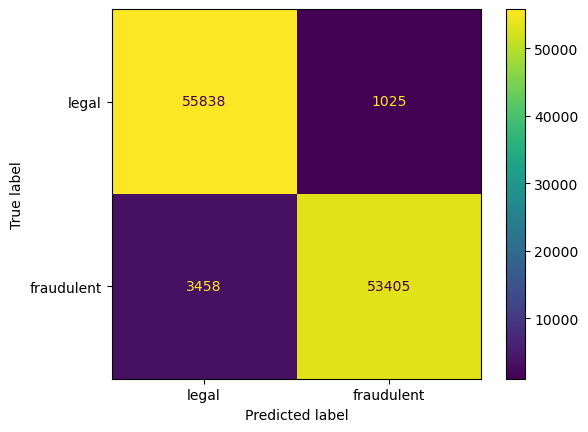




*****************************************************
FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56862

    accuracy                           0.96    113725
   macro avg       0.96      0.96      0.96    113725
weighted avg       0.96      0.96      0.96    113725

--------------CONFUSION MATRIX--------------



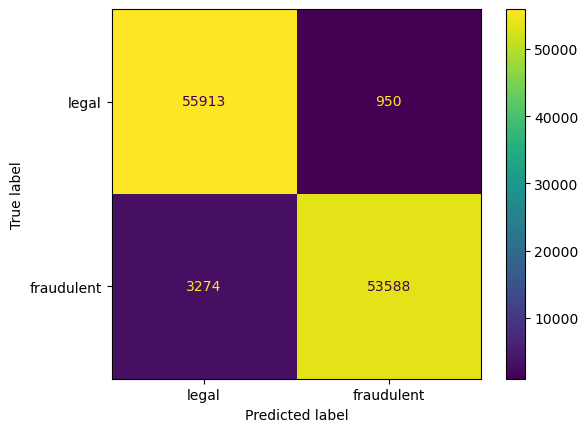




 ---------------------------------------------
 --------------- GENERAL STATISTICS --------------- 

Accuracy per round: 
[0.9616358616323444, 0.9623480998188629, 0.9627086154441377, 0.9605806939486133, 0.9628577709386679]
Precision per round: 
[0.9625120832275713, 0.9631297074290858, 0.9635090505440673, 0.9614254400880677, 0.9636323757686884]
Recall per round: 
[0.9616358616323444, 0.9623480998188629, 0.9627086154441377, 0.9605806939486132, 0.962857591245662]
F1-score per round: 
[0.9616176829640017, 0.9623322071687774, 0.9626925088409446, 0.9605626441451054, 0.9628422405064369]
AUC per round: 
[0.9625120832275713, 0.9631297074290858, 0.9635090505440673, 0.9614254400880676, 0.9636323757686885]
Fit_time per round: 
['3.49', '2.09', '3.67', '2.17', '1.8']
The average accuracy is:  0.9620262083565253
The average precision is:  0.9628417314114962
The average recall is:  0.962026172417924
The average F1-score is:  0.9620094567250532
The average AUC is:  0.9628417314114961
The average fi

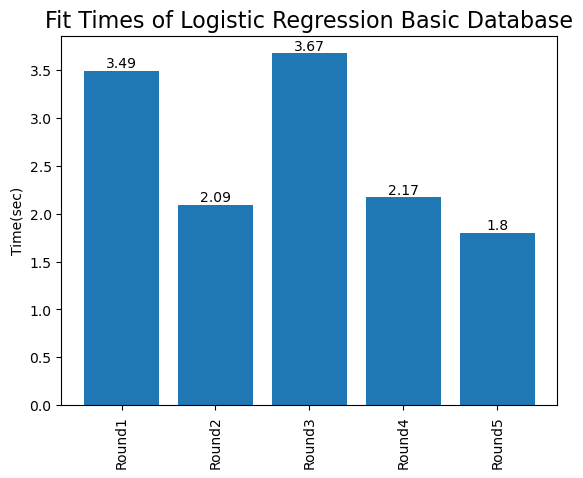



------------------------------------------------------------




In [22]:
target = df_mms['Class']
data = df_mms.drop('Class', axis = 1)
(lr_df_mms_acc_arr, lr_df_mms_acc, lr_df_mms_ft) = kfoldLogisticRegression(target, data)


.

### Logistic Regression on Z-score Scaled Dataset

In [23]:
df_zs.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-5.348167e-17,-5.223210e-18,1.028710e-17,-5.298184e-18,-6.847653e-18,1.524478e-17,8.397122e-18,-7.197533e-18,-1.422138e-16,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-1.938361e+01,-7.735086e+00,-3.029648e+01,-4.067970e+00,-1.361262e+01,-8.226963e+00,-1.049864e+01,-3.903536e+01,-1.733030e+00,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-1.664365e-01,-4.905153e-01,-2.376262e-01,-6.515818e-01,-5.541480e-01,-6.318948e-01,-3.049585e-01,-2.318753e-01,-8.652311e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,-3.741858e-02,-2.733978e-02,-5.968015e-02,1.590069e-02,-8.193326e-03,-1.189111e-02,-1.729089e-01,-1.392600e-02,-1.706617e-03,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,1.479986e-01,4.638922e-01,1.557313e-01,7.007386e-01,5.500151e-01,6.728875e-01,3.340244e-01,4.095939e-01,8.662877e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,8.087552e+00,1.263295e+01,3.170873e+01,1.296564e+01,1.462150e+01,5.623280e+00,1.132312e+02,7.725619e+01,1.733906e+00,1.000000





*****************************************************
FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.97      0.96      0.96    113726
weighted avg       0.97      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



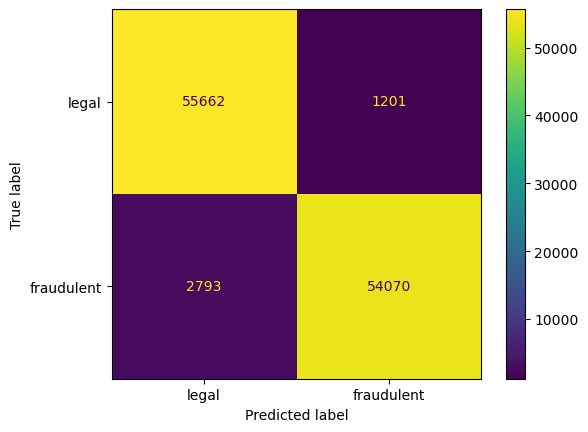




*****************************************************
FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

--------------CONFUSION MATRIX--------------



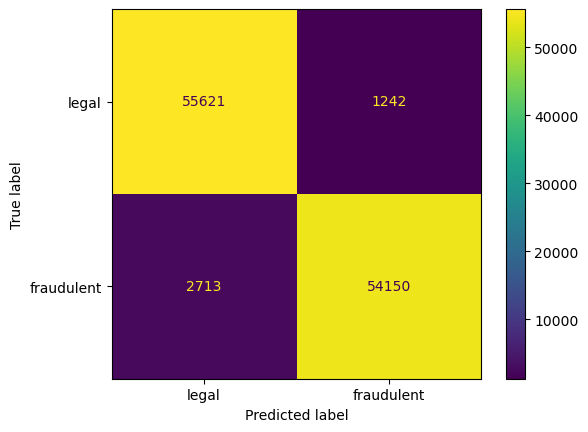




*****************************************************
FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

--------------CONFUSION MATRIX--------------



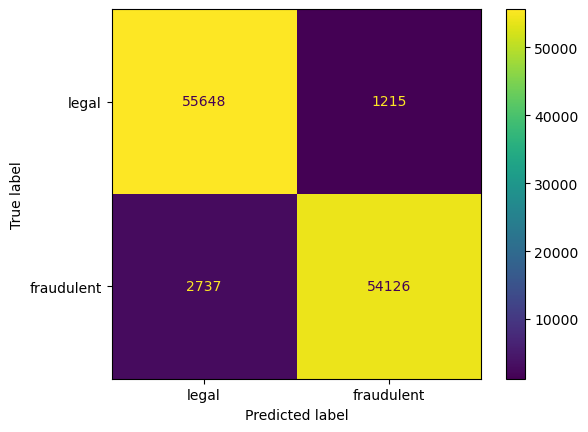




*****************************************************
FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



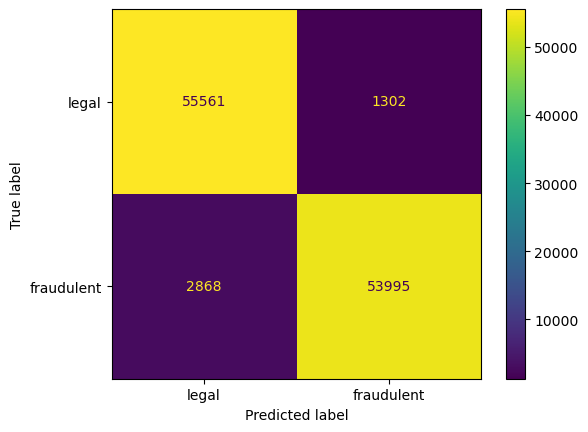




*****************************************************
FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.97     56862

    accuracy                           0.97    113725
   macro avg       0.97      0.97      0.97    113725
weighted avg       0.97      0.97      0.97    113725

--------------CONFUSION MATRIX--------------



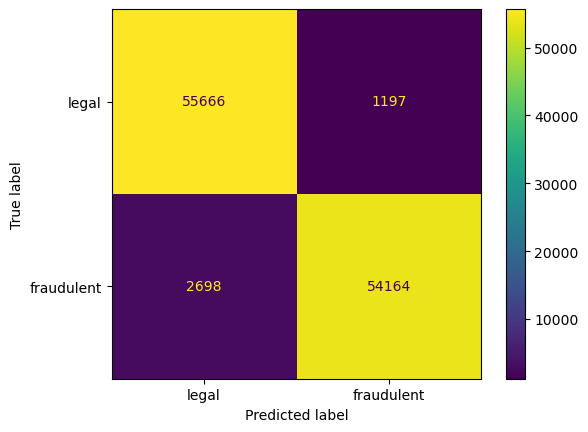




 ---------------------------------------------
 --------------- GENERAL STATISTICS --------------- 

Accuracy per round: 
[0.9648805022598175, 0.9652234317570301, 0.9652498109491233, 0.9633329229903452, 0.9657507144427346]
Precision per round: 
[0.9652451793420773, 0.9655349748466355, 0.9655833657709737, 0.9636846021657604, 0.9660755772142045]
Recall per round: 
[0.9648805022598175, 0.9652234317570301, 0.9652498109491233, 0.9633329229903452, 0.965750598383765]
F1-score per round: 
[0.9648736189073744, 0.9652176125312782, 0.9652435858719541, 0.9633259691833519, 0.9657447392041258]
AUC per round: 
[0.9652451793420773, 0.9655349748466356, 0.9655833657709737, 0.9636846021657605, 0.9660755772142046]
Fit_time per round: 
['1.03', '0.49', '0.13', '0.27', '0.99']
The average accuracy is:  0.9648874764798101
The average precision is:  0.9652247398679302
The average recall is:  0.9648874532680163
The average F1-score is:  0.9648811051396169
The average AUC is:  0.9652247398679303
The average 

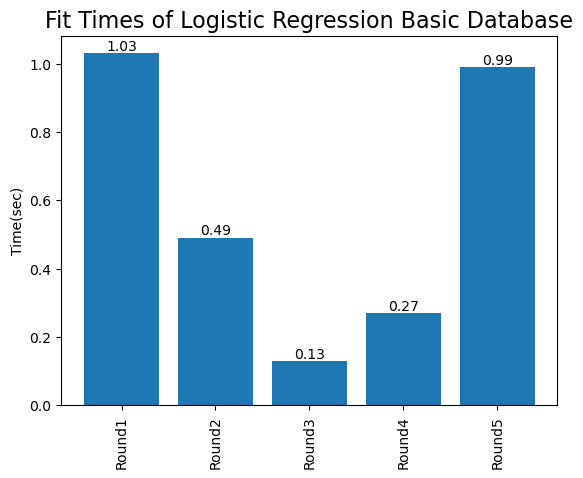



------------------------------------------------------------




In [24]:
target = df_zs['Class']
data = df_zs.drop('Class', axis = 1)
(lr_df_zs_acc_arr, lr_df_zs_acc, lr_df_zs_ft) = kfoldLogisticRegression(target, data)

.

### Logistic Regression on Reduced MinMax Scaled Dataset

In [25]:
df_mms_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.101355,0.099047,0.045317,0.262150,0.263093,0.670724,0.705598,0.084851,0.335668,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.050166,0.046999,0.020464,0.105496,0.108629,0.085935,0.036402,0.008082,0.008599,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.059660,0.058007,0.030660,0.196797,0.202692,0.622144,0.699540,0.082387,0.333674,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.109484,0.109880,0.048059,0.290807,0.272576,0.668492,0.704236,0.083454,0.335548,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.138712,0.134382,0.058733,0.316821,0.322230,0.718858,0.710986,0.087551,0.339190,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





*****************************************************
FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



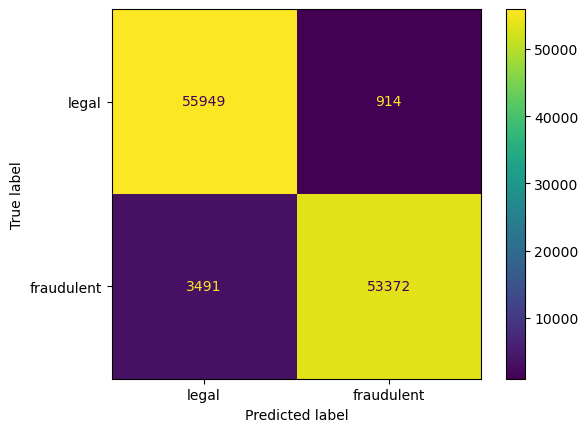




*****************************************************
FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



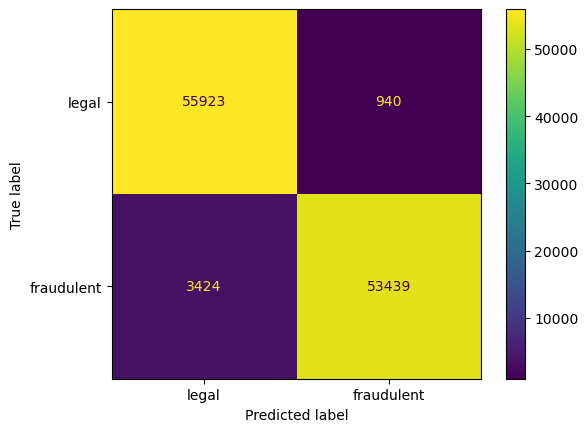




*****************************************************
FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



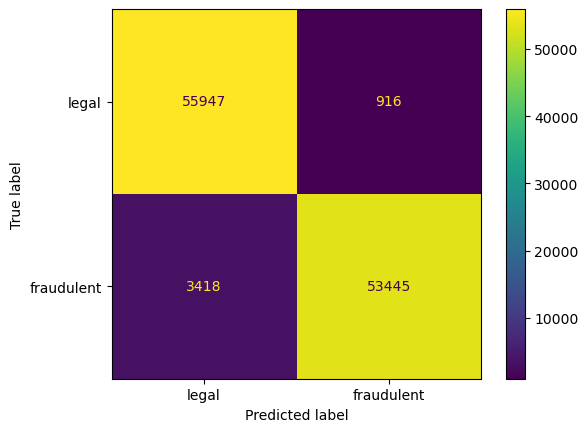




*****************************************************
FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



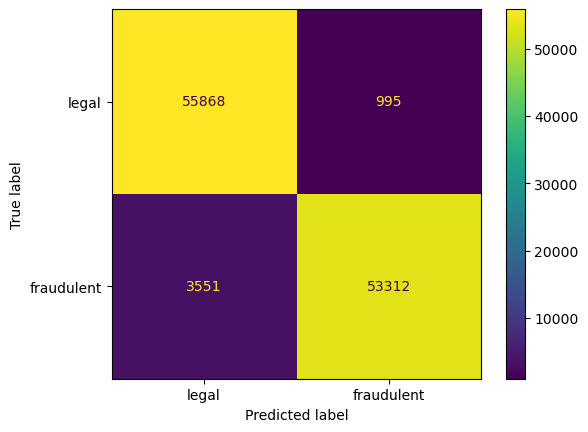




*****************************************************
FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56863
           1       0.98      0.94      0.96     56862

    accuracy                           0.96    113725
   macro avg       0.96      0.96      0.96    113725
weighted avg       0.96      0.96      0.96    113725

--------------CONFUSION MATRIX--------------



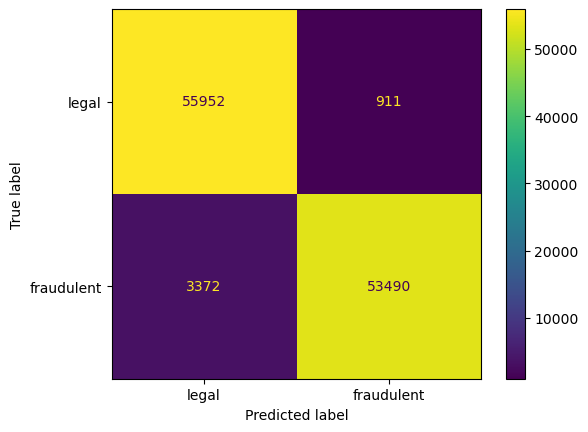




 ---------------------------------------------
 --------------- GENERAL STATISTICS --------------- 

Accuracy per round: 
[0.9612665529430385, 0.9616270685683133, 0.9618908604892461, 0.9600267309146545, 0.9623389755990328]
Precision per round: 
[0.9622158762828783, 0.9625096696648641, 0.9627868358571585, 0.9609581038553867, 0.9632067912203961]
Recall per round: 
[0.9612665529430385, 0.9616270685683133, 0.9618908604892461, 0.9600267309146545, 0.9623387853132379]
F1-score per round: 
[0.9612466545269291, 0.9616087531909525, 0.9618724063208648, 0.9600065290588193, 0.9623213168504952]
AUC per round: 
[0.9622158762828782, 0.9625096696648641, 0.9627868358571585, 0.9609581038553867, 0.9632067912203961]
Fit_time per round: 
['1.83', '0.76', '2.39', '1.81', '0.57']
The average accuracy is:  0.9614300377028571
The average precision is:  0.9623354553761366
The average recall is:  0.9614299996456982
The average F1-score is:  0.9614111319896121
The average AUC is:  0.9623354553761366
The average

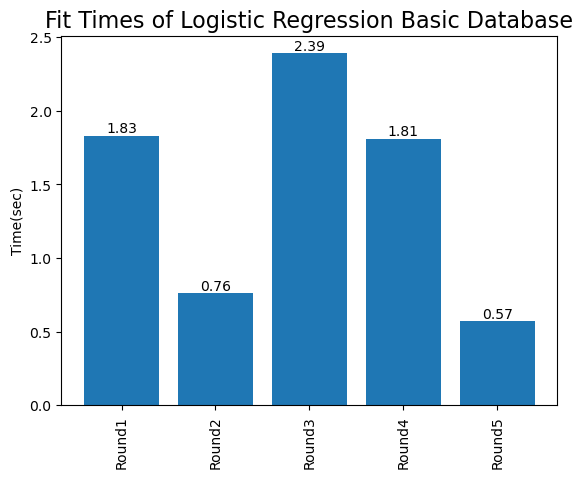



------------------------------------------------------------




In [26]:
target = df_mms_reduced['Class']
data = df_mms_reduced.drop('Class', axis = 1)
(lr_df_mms_red_acc_arr, lr_df_mms_red_acc, lr_df_mms_red_ft) = kfoldLogisticRegression(target, data)


.

### Logistic Regression on Reduced Z-score Scaled Dataset

In [27]:
df_zs_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-2.007312e-16,6.077917e-17,-2.639096e-17,1.167600e-16,2.479150e-17,-9.976581e-17,-5.348167e-17,8.397122e-18,-7.197533e-18,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-2.020400e+00,-2.107420e+00,-2.214516e+00,-2.484939e+00,-2.421950e+00,-7.804982e+00,-1.938361e+01,-1.049864e+01,-3.903536e+01,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-8.311350e-01,-8.732063e-01,-7.162625e-01,-6.194854e-01,-5.560383e-01,-5.653081e-01,-1.664365e-01,-3.049585e-01,-2.318753e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,1.620507e-01,2.304996e-01,1.340253e-01,2.716395e-01,8.729456e-02,-2.597802e-02,-3.741858e-02,-1.729089e-01,-1.392600e-02,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,7.446707e-01,7.518204e-01,6.556051e-01,5.182237e-01,5.443876e-01,5.601177e-01,1.479986e-01,3.340244e-01,4.095939e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,1.791355e+01,1.916955e+01,4.665293e+01,6.994120e+00,6.783714e+00,3.831668e+00,8.087552e+00,1.132312e+02,7.725619e+01,1.000000





*****************************************************
FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.97      0.96      0.96    113726
weighted avg       0.97      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



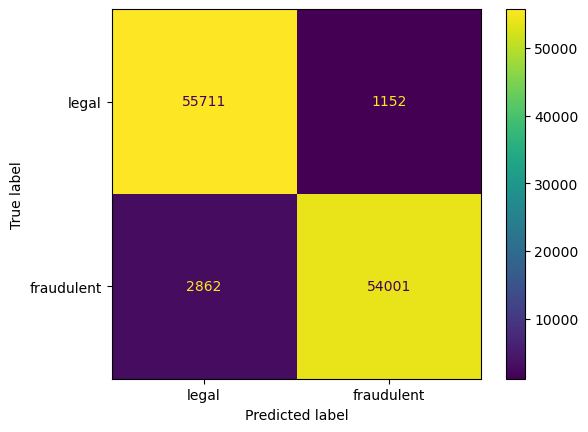




*****************************************************
FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

--------------CONFUSION MATRIX--------------



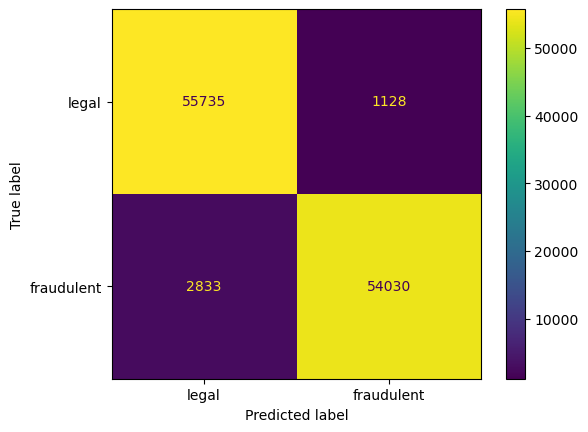




*****************************************************
FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

--------------CONFUSION MATRIX--------------



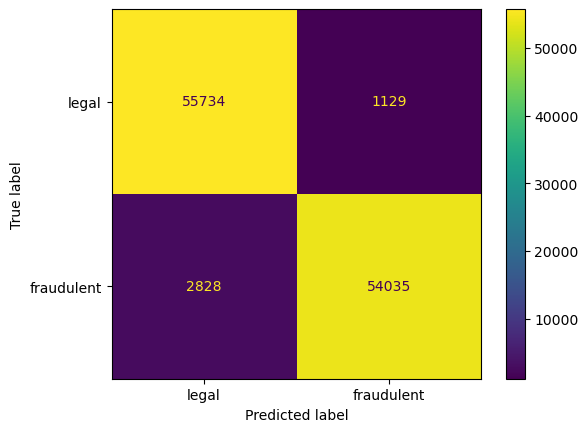




*****************************************************
FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

--------------CONFUSION MATRIX--------------



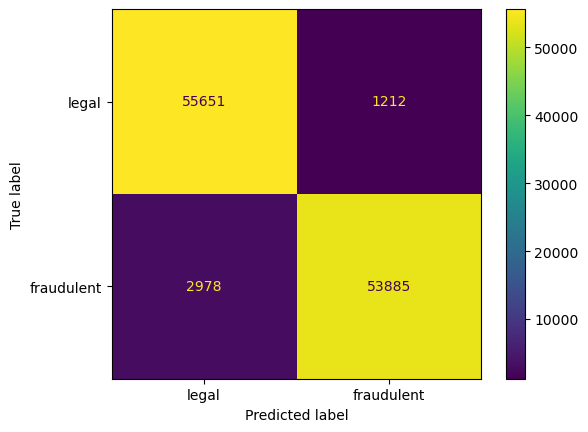




*****************************************************
FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.97     56862

    accuracy                           0.97    113725
   macro avg       0.97      0.97      0.97    113725
weighted avg       0.97      0.97      0.97    113725

--------------CONFUSION MATRIX--------------



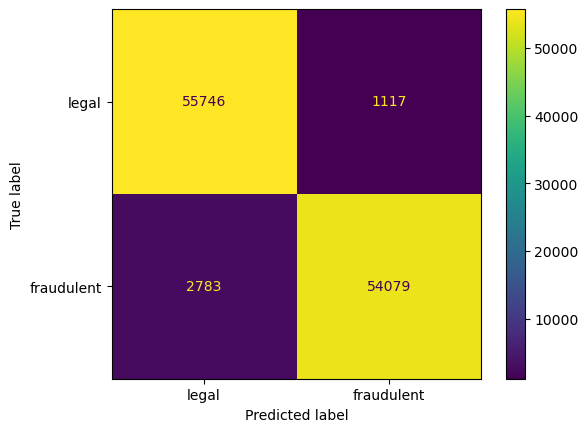




 ---------------------------------------------
 --------------- GENERAL STATISTICS --------------- 

Accuracy per round: 
[0.9647046409791956, 0.9651706733728435, 0.9652058456289678, 0.9631570617097234, 0.9657067487359859]
Precision per round: 
[0.9651252732820774, 0.9655892665923083, 0.9656215267216249, 0.9636042281983879, 0.9661069740357664]
Recall per round: 
[0.9647046409791955, 0.9651706733728436, 0.9652058456289678, 0.9631570617097234, 0.9657066199193227]
F1-score per round: 
[0.9646966594061085, 0.9651628431893144, 0.9651980783222609, 0.9631481754118858, 0.9656993788411035]
AUC per round: 
[0.9651252732820773, 0.9655892665923083, 0.9656215267216249, 0.963604228198388, 0.9661069740357666]
Fit_time per round: 
['0.14', '0.47', '0.39', '0.42', '0.18']
The average accuracy is:  0.9647889940853431
The average precision is:  0.9652094537660331
The average recall is:  0.9647889683220106
The average F1-score is:  0.9647810270341347
The average AUC is:  0.9652094537660331
The average 

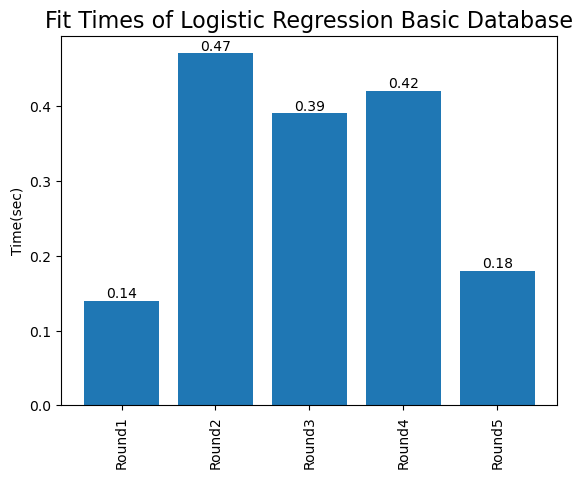



------------------------------------------------------------




In [28]:
target = df_zs_reduced['Class']
data = df_zs_reduced.drop('Class', axis = 1)
(lr_df_zs_red_acc_arr, lr_df_zs_red_acc, lr_df_zs_red_ft) = kfoldLogisticRegression(target, data)

.

### Performance Evaluation of Logistic Regression Classifiers

The Logistic Regression classifiers have had better performances with the reduced datasets in terms of fit-time, as we expected. The Z-score classifiers had better performances both in terms of fit-time and accuracy than the MinMax classifiers. Moreover the Reduced Datasets classifiers had a little worse performance than the Not Reduced Datasets ones, as we can see from the following plots. This could be due to lost information into the removed feature. 


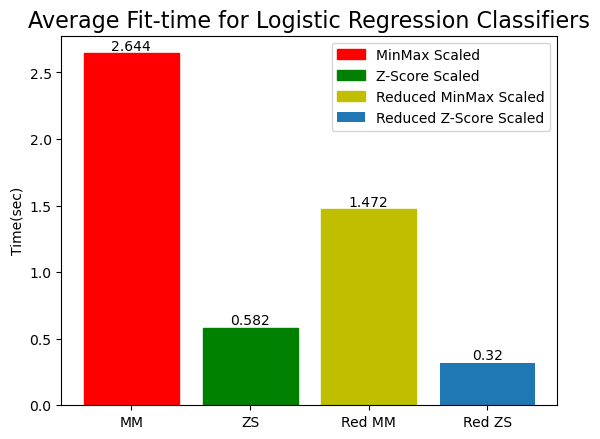

In [29]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3,4], [lr_df_mms_ft, lr_df_zs_ft, lr_df_mms_red_ft, lr_df_zs_red_ft], 
               label = ['MinMax Scaled', 'Z-Score Scaled', 'Reduced MinMax Scaled', 'Reduced Z-Score Scaled'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3,4],['MM', 'ZS', 'Red MM', 'Red ZS'])
plt.title('Average Fit-time for Logistic Regression Classifiers', fontsize = 16);
plt.ylabel('Time(sec)')
plt.show()

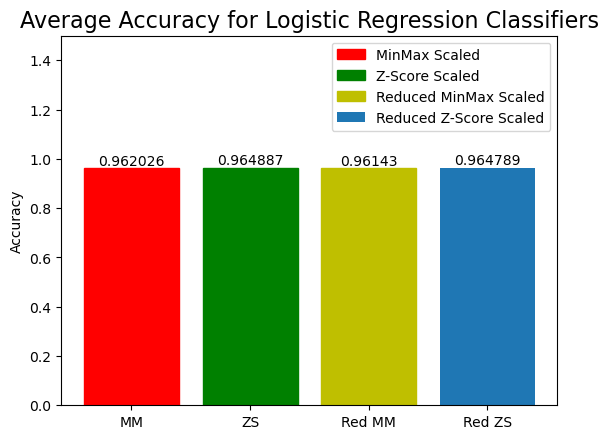

In [30]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3,4], [lr_df_mms_acc, lr_df_zs_acc, lr_df_mms_red_acc, lr_df_zs_red_acc], 
               label = ['MinMax Scaled', 'Z-Score Scaled', 'Reduced MinMax Scaled', 'Reduced Z-Score Scaled'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3,4],['MM', 'ZS', 'Red MM', 'Red ZS'])
plt.title('Average Accuracy for Logistic Regression Classifiers', fontsize = 16);
plt.ylabel('Accuracy')
plt.ylim((0, 1.5))
plt.show()

It is been mplemented a function for the measurment of the t-test value between two classifiers, to understand if one of the two is statistically better than the other one according to a determined metric. The function is represented below and we will use it also for the comparison with the other kind of classifiers.

In [31]:
def t_test(model1, classifier1_arr, model2, classifier2_arr, confidence):
    
    stat, p_value = ttest_ind(classifier1_arr, classifier2_arr)
    a = confidence

    if p_value <= a:
        print(f"The Null Hypothesis is set at a confidence level of {confidence*100}%")
        acc_mean_1 = mean(classifier1_arr)
        acc_mean_2 = mean(classifier2_arr)
        if(acc_mean_1 > acc_mean_2):
            best = model1
        else:
            best = model2

        print("Distributions are statistically different in terms of accuracy. The best classifier is the "+ best)

    else:
        print("The Null Hypothesis cannot be rejected")
        print("There is not statistically difference between the classifiers")

I also performed a t-test between the MinMax Scaled Dataset and the Z-Score Scaled Dataset and we obtained that:

In [32]:
t_test("MinMax Scaled", lr_df_mms_acc_arr, "Z-Score Scaled", lr_df_zs_acc_arr, 0.05)

The Null Hypothesis is set at a confidence level of 5.0%
Distributions are statistically different in terms of accuracy. The best classifier is the Z-Score Scaled



.

-----


## Neural Network

For the implementation of the neural network classifier many configurations have been tried to understand which one would have acceptable fit time but, at the same time, good performance. The configuration I decided to report is based on "alan" classifier and 10 neurons on one hidden layer. Moreover, due to the fact that the Neural Network classifier is so badly influenced by not scaled data, I decided to have the study on this classifer only on the Reduced MinMax Scaled Dataset and on the Reduced Z-Score Scaled Dataset. 

The function of the neural network classifier and of the statistics obtained I use is defined below:

In [33]:
def kfoldNeuralNetwork(target, data):
    df_target = target
    df_data = data

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
    
    fit_time = []
    round_acc = []
    round_auc = []
    round_prec = []
    round_rec = []
    round_f1s = []
    
    
    #Training and Prediction
    k = 1
    for train, test in skf.split(np.zeros(len(df_target)), df_target):
        print(f'FOLD {k}')
        
        X_tr = df_data.iloc[train]
        y_tr = df_target.iloc[train]
        X_te = df_data.iloc[test]
        y_te = df_target.iloc[test]

        NN = MLPClassifier(solver = 'adam', max_iter = 500, hidden_layer_sizes = (10), random_state = 0)

        start = time.time()
        NN.fit(X_tr,y_tr)
        end = time.time()

        fit_time.append(str(round(end-start, 2)))
        
        y_pred = NN.predict(X_te)

        print("----------- CLASSIFICATION REPORT --------------\n")
        cr = classification_report(y_te, y_pred, output_dict = True)
        print(classification_report(y_te, y_pred))
        
        round_acc.append(cr['accuracy'])
        round_prec.append(cr['macro avg']['precision'])
        round_rec.append(cr['macro avg']['recall'])
        round_f1s.append(cr['macro avg']['f1-score'])
        round_auc.append(roc_auc_score(y_pred, y_te))
        
        print("--------------CONFUSION MATRIX--------------\n")
        ConfusionMatrixDisplay.from_predictions(y_te, y_pred, display_labels = ['legal','fraudulent'])
        plt.show()
            
        k += 1
        
    print("\n\n\n---------------------------------\n -------------- GENERAL STATISTICS ------------\n")
    print("Accuracy per round: ")
    print(round_acc)

    print("Precision per round: ")
    print(round_prec)

    print("Recall per round: ")
    print(round_rec)

    print("F1-score per round: ")
    print(round_f1s)

    print("AUC per round: ")
    print(round_auc)
    
    print("Fit_time per round: ")
    print(fit_time)

    avg_acc = np.mean(round_acc)
    print("The average accuracy is: ", avg_acc)

    avg_prec = np.mean(round_prec)
    print("The average precision is: ", avg_prec)

    avg_rec = np.mean(round_rec)
    print("The average recall is: ", avg_rec)

    avg_f1s = np.mean(round_f1s)
    print("The average F1-score is: ", avg_f1s)

    avg_auc = np.mean(round_auc)
    print("The average AUC is: ", avg_auc)
        
    fit_time = [float(i) for i in fit_time]
        
    avg_fit_time = np.mean(fit_time)
    print("The average fit-time is: ", avg_fit_time, "seconds\n\n")  

    rounds = ["Round1", "Round2", "Round3", "Round4", "Round5"]
    fig, ax = plt.subplots()
    plot = plt.bar(rounds, fit_time)
    ax.bar_label(plot)
    plt.xticks(np.arange(5), ['Round1', 'Round2', 'Round3', 'Round4', 'Round5'], rotation = 'vertical')
    plt.title('Fit Times of Logistic Regression Basic Database', fontsize = 16);
    plt.ylabel("Time(sec)")
    plt.show()

    print("\n\n------------------------------------------------\n\n")
    return (round_acc, avg_acc, avg_fit_time)


.

### Neural Network on MinMax Scaled Dataset

In [34]:
df_mms.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.705598,0.379766,0.488612,0.238820,0.482134,0.593994,0.084851,0.335668,0.499874,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.036402,0.049097,0.016128,0.058708,0.035418,0.072201,0.008082,0.008599,0.288439,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.699540,0.355683,0.484780,0.200568,0.462507,0.548371,0.082387,0.333674,0.250307,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.704236,0.378424,0.487649,0.239754,0.481844,0.593136,0.083454,0.335548,0.499381,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.710986,0.402541,0.491123,0.279959,0.501614,0.642577,0.087551,0.339190,0.749745,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

--------------CONFUSION MATRIX--------------



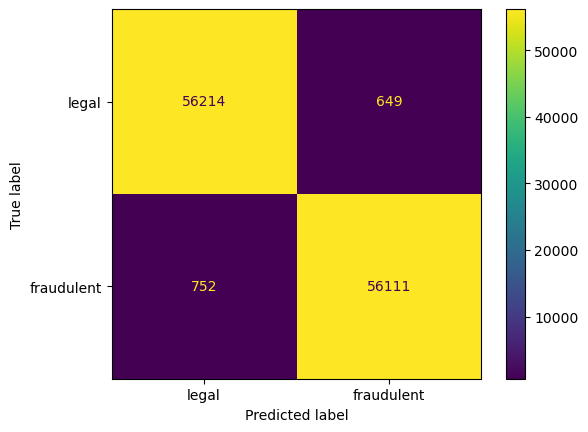

FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

--------------CONFUSION MATRIX--------------



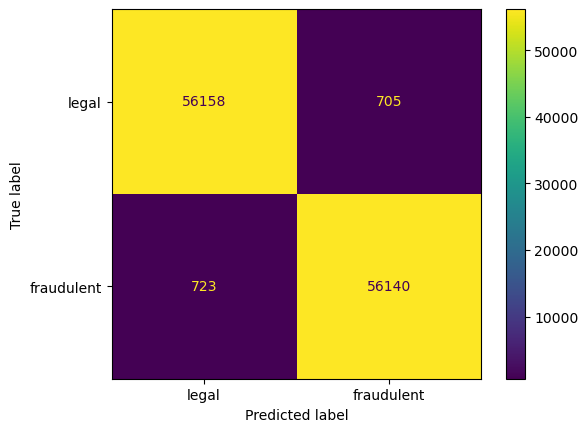

FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     56863
           1       0.97      0.99      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

--------------CONFUSION MATRIX--------------



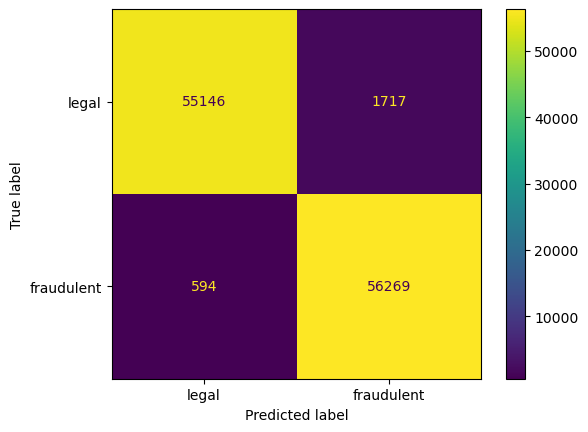

FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     56863
           1       0.98      0.99      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

--------------CONFUSION MATRIX--------------



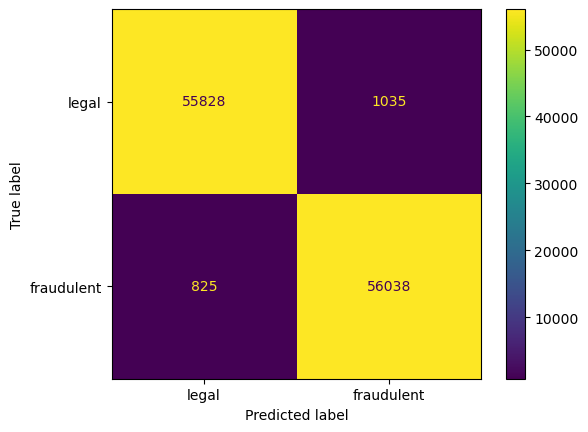

FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     56863
           1       0.98      0.99      0.99     56862

    accuracy                           0.99    113725
   macro avg       0.99      0.99      0.99    113725
weighted avg       0.99      0.99      0.99    113725

--------------CONFUSION MATRIX--------------



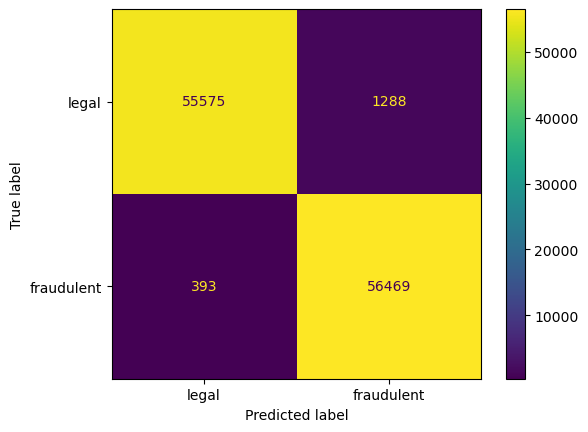




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9876809172924397, 0.9874435045636002, 0.9796792290241457, 0.9836449009021684, 0.9852187293910749]
Precision per round: 
[0.9876825174107662, 0.9874435534074406, 0.979866392158725, 0.9836514973721262, 0.9853389015635716]
Recall per round: 
[0.9876809172924397, 0.9874435045636003, 0.9796792290241458, 0.9836449009021684, 0.9852187985907368]
F1-score per round: 
[0.9876809071875019, 0.9874435042490471, 0.9796772473943927, 0.9836448451356257, 0.9852178159053749]
AUC per round: 
[0.9876825174107663, 0.9874435534074407, 0.9798663921587248, 0.9836514973721261, 0.9853389015635717]
Fit_time per round: 
['674.22', '722.53', '348.85', '473.81', '397.27']
The average accuracy is:  0.9847334562346859
The average precision is:  0.9847965723825259
The average recall is:  0.9847334700746181
The average F1-score is:  0.9847328639743884
The average AUC is:  0.9847965723825259
The average fit-time

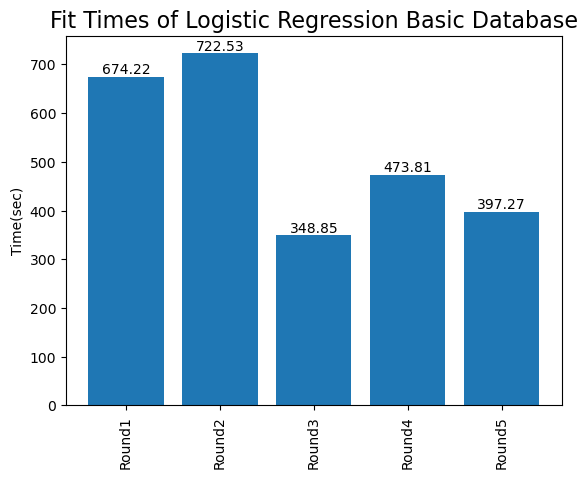



------------------------------------------------




In [35]:
target = df_mms['Class']
data = df_mms.drop('Class', axis = 1)
(nn_df_mms_acc_arr, nn_df_mms_acc, nn_df_mms_ft) = kfoldNeuralNetwork(target, data)


.

### Neural Network on Z-score Scaled Dataset

In [36]:
df_zs.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-5.348167e-17,-5.223210e-18,1.028710e-17,-5.298184e-18,-6.847653e-18,1.524478e-17,8.397122e-18,-7.197533e-18,-1.422138e-16,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-1.938361e+01,-7.735086e+00,-3.029648e+01,-4.067970e+00,-1.361262e+01,-8.226963e+00,-1.049864e+01,-3.903536e+01,-1.733030e+00,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-1.664365e-01,-4.905153e-01,-2.376262e-01,-6.515818e-01,-5.541480e-01,-6.318948e-01,-3.049585e-01,-2.318753e-01,-8.652311e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,-3.741858e-02,-2.733978e-02,-5.968015e-02,1.590069e-02,-8.193326e-03,-1.189111e-02,-1.729089e-01,-1.392600e-02,-1.706617e-03,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,1.479986e-01,4.638922e-01,1.557313e-01,7.007386e-01,5.500151e-01,6.728875e-01,3.340244e-01,4.095939e-01,8.662877e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,8.087552e+00,1.263295e+01,3.170873e+01,1.296564e+01,1.462150e+01,5.623280e+00,1.132312e+02,7.725619e+01,1.733906e+00,1.000000


FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------CONFUSION MATRIX--------------



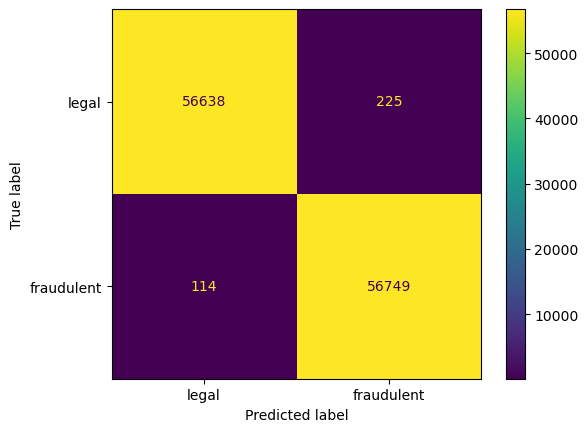

FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------CONFUSION MATRIX--------------



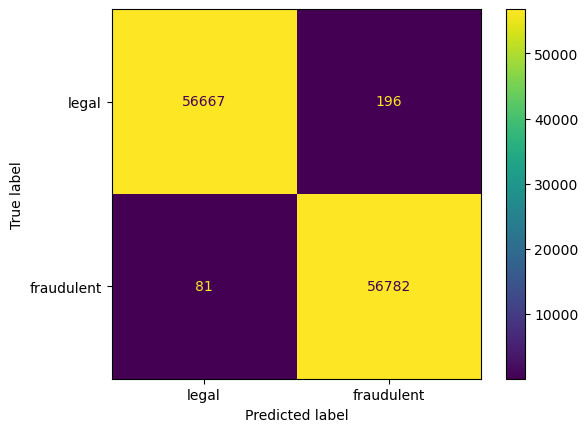

FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------CONFUSION MATRIX--------------



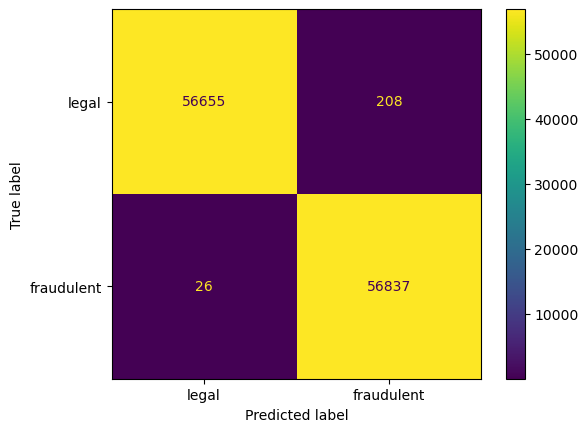

FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------CONFUSION MATRIX--------------



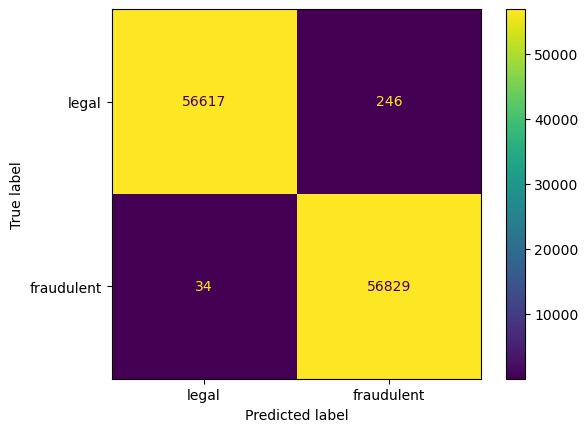

FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56862

    accuracy                           1.00    113725
   macro avg       1.00      1.00      1.00    113725
weighted avg       1.00      1.00      1.00    113725

--------------CONFUSION MATRIX--------------



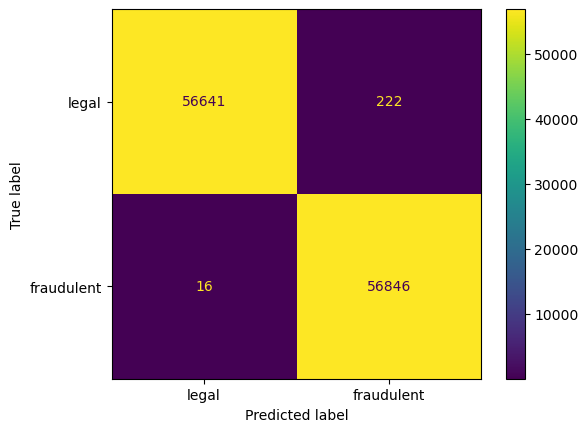




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9970191512934597, 0.9975643212633875, 0.9979424230167244, 0.9975379420712942, 0.9979072323587602]
Precision per round: 
[0.9970210452115773, 0.9975663563699311, 0.9979475241517115, 0.9975448579031663, 0.9979137514293609]
Recall per round: 
[0.9970191512934596, 0.9975643212633873, 0.9979424230167244, 0.9975379420712942, 0.9979072482863813]
F1-score per round: 
[0.9970191484537968, 0.9975643187728298, 0.9979424177470904, 0.9975379335156647, 0.9979072255586139]
AUC per round: 
[0.9970210452115773, 0.9975663563699311, 0.9979475241517115, 0.9975448579031662, 0.9979137514293609]
Fit_time per round: 
['14.09', '104.48', '15.08', '108.07', '11.05']
The average accuracy is:  0.9975942140007252
The average precision is:  0.9975987070131493
The average recall is:  0.9975942171862494
The average F1-score is:  0.997594208809599
The average AUC is:  0.9975987070131493
The average fit-time is

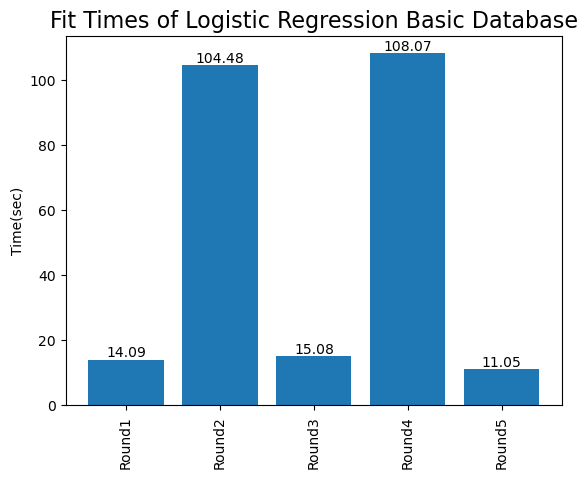



------------------------------------------------




In [37]:
target = df_zs['Class']
data = df_zs.drop('Class', axis = 1)
(nn_df_zs_acc_arr, nn_df_zs_acc, nn_df_zs_ft) = kfoldNeuralNetwork(target, data)


.

### Neural Network on Reduced MinMax Scaled Dataset

In [38]:
df_mms_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.101355,0.099047,0.045317,0.262150,0.263093,0.670724,0.705598,0.084851,0.335668,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.050166,0.046999,0.020464,0.105496,0.108629,0.085935,0.036402,0.008082,0.008599,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.059660,0.058007,0.030660,0.196797,0.202692,0.622144,0.699540,0.082387,0.333674,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.109484,0.109880,0.048059,0.290807,0.272576,0.668492,0.704236,0.083454,0.335548,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.138712,0.134382,0.058733,0.316821,0.322230,0.718858,0.710986,0.087551,0.339190,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56863
           1       0.98      0.98      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

--------------CONFUSION MATRIX--------------



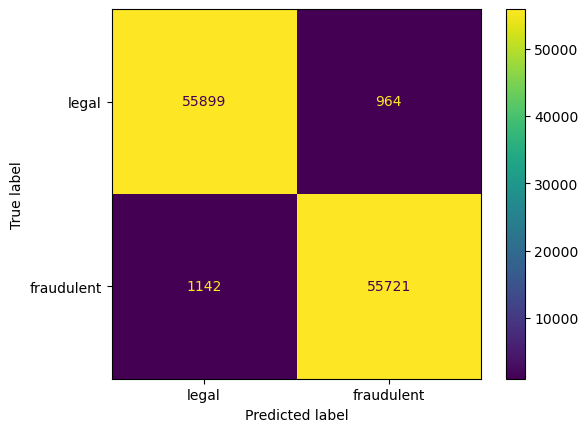

FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56863
           1       0.98      0.98      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

--------------CONFUSION MATRIX--------------



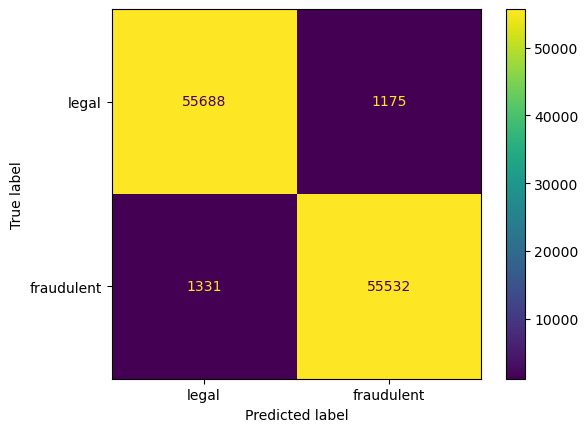

FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56863
           1       0.99      0.97      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

--------------CONFUSION MATRIX--------------



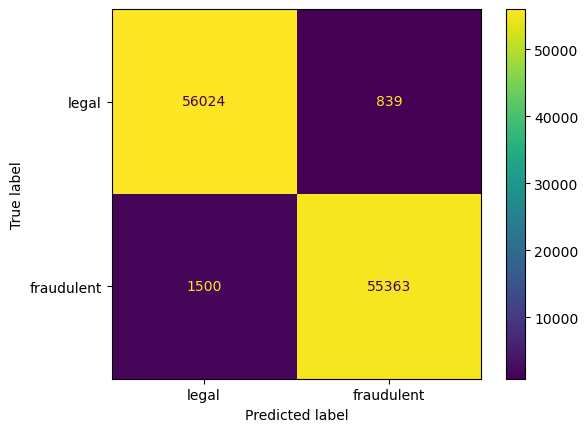

FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56863
           1       0.99      0.97      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

--------------CONFUSION MATRIX--------------



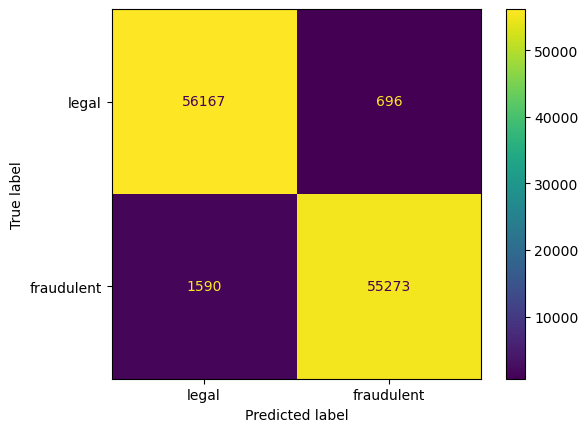

FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56863
           1       0.98      0.97      0.98     56862

    accuracy                           0.98    113725
   macro avg       0.98      0.98      0.98    113725
weighted avg       0.98      0.98      0.98    113725

--------------CONFUSION MATRIX--------------



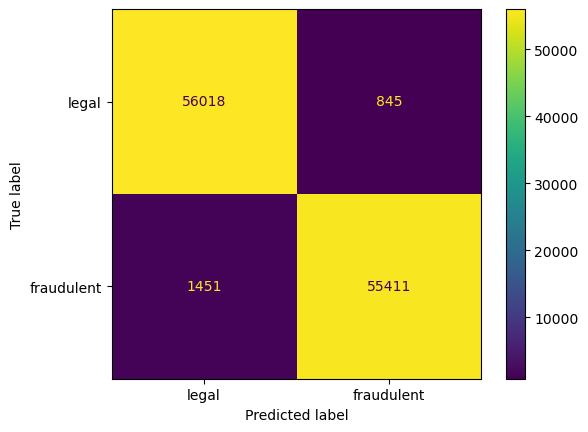




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9814818071505197, 0.9779645815380827, 0.9794330232312751, 0.9798990556249231, 0.9798109474609804]
Precision per round: 
[0.9814865252229625, 0.9779681789373641, 0.9794978165187327, 0.9800177069952531, 0.9798654925952461]
Recall per round: 
[0.9814818071505196, 0.9779645815380827, 0.9794330232312751, 0.9798990556249231, 0.9798109006039025]
F1-score per round: 
[0.9814817617856004, 0.9779645400759357, 0.9794323284173411, 0.9798978134040887, 0.9798103722941907]
AUC per round: 
[0.9814865252229625, 0.9779681789373642, 0.9794978165187326, 0.9800177069952531, 0.9798654925952461]
Fit_time per round: 
['405.88', '517.51', '303.3', '355.33', '251.29']
The average accuracy is:  0.9797178830011563
The average precision is:  0.9797671440539117
The average recall is:  0.9797178736297406
The average F1-score is:  0.9797173631954312
The average AUC is:  0.9797671440539117
The average fit-time

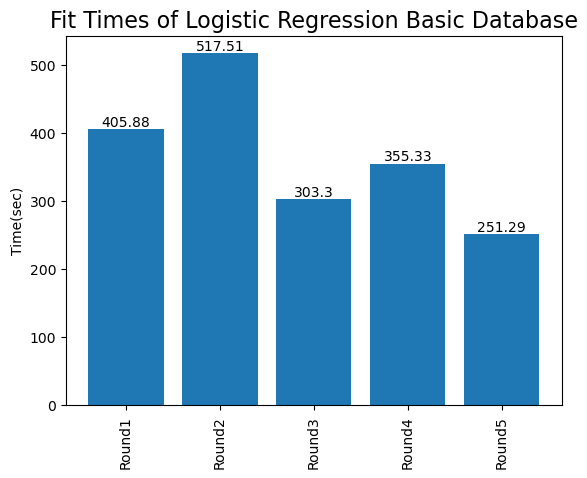



------------------------------------------------




In [39]:
target = df_mms_reduced['Class']
data = df_mms_reduced.drop('Class', axis = 1)
(nn_df_mms_red_acc_arr, nn_df_mms_red_acc, nn_df_mms_red_ft) = kfoldNeuralNetwork(target, data)


.

### Neural Network on Reduced Z-Score Scaled Dataset

In [40]:
df_zs_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-2.007312e-16,6.077917e-17,-2.639096e-17,1.167600e-16,2.479150e-17,-9.976581e-17,-5.348167e-17,8.397122e-18,-7.197533e-18,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-2.020400e+00,-2.107420e+00,-2.214516e+00,-2.484939e+00,-2.421950e+00,-7.804982e+00,-1.938361e+01,-1.049864e+01,-3.903536e+01,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-8.311350e-01,-8.732063e-01,-7.162625e-01,-6.194854e-01,-5.560383e-01,-5.653081e-01,-1.664365e-01,-3.049585e-01,-2.318753e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,1.620507e-01,2.304996e-01,1.340253e-01,2.716395e-01,8.729456e-02,-2.597802e-02,-3.741858e-02,-1.729089e-01,-1.392600e-02,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,7.446707e-01,7.518204e-01,6.556051e-01,5.182237e-01,5.443876e-01,5.601177e-01,1.479986e-01,3.340244e-01,4.095939e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,1.791355e+01,1.916955e+01,4.665293e+01,6.994120e+00,6.783714e+00,3.831668e+00,8.087552e+00,1.132312e+02,7.725619e+01,1.000000


FOLD 1
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

--------------CONFUSION MATRIX--------------



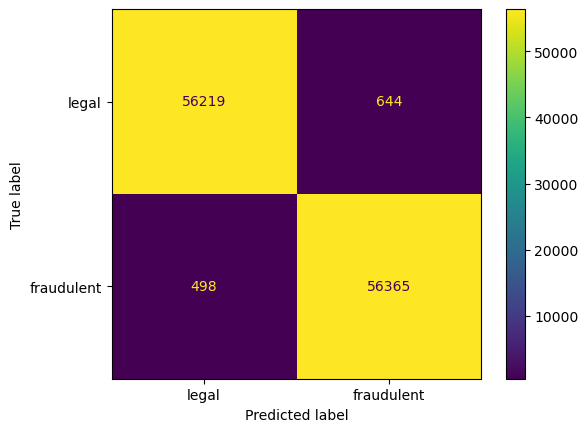

FOLD 2
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

--------------CONFUSION MATRIX--------------



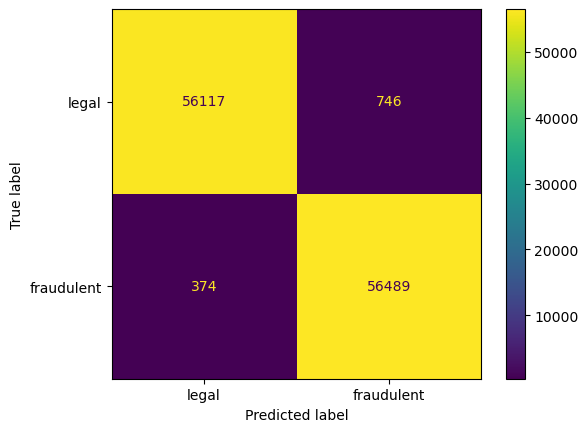

FOLD 3
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

--------------CONFUSION MATRIX--------------



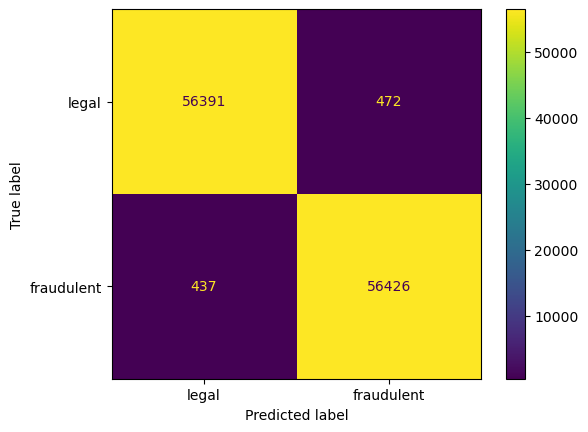

FOLD 4
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.99      1.00      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

--------------CONFUSION MATRIX--------------



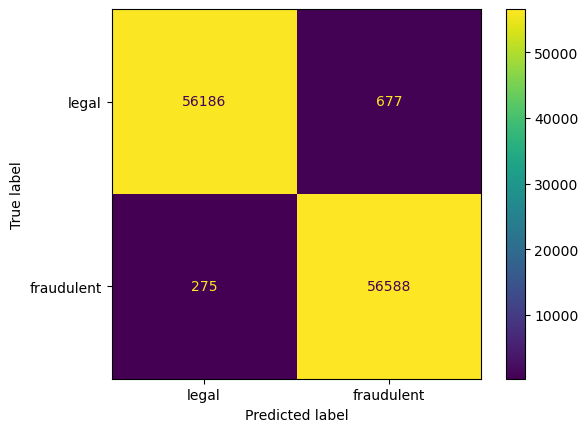

FOLD 5
----------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.99      1.00      0.99     56862

    accuracy                           0.99    113725
   macro avg       0.99      0.99      0.99    113725
weighted avg       0.99      0.99      0.99    113725

--------------CONFUSION MATRIX--------------



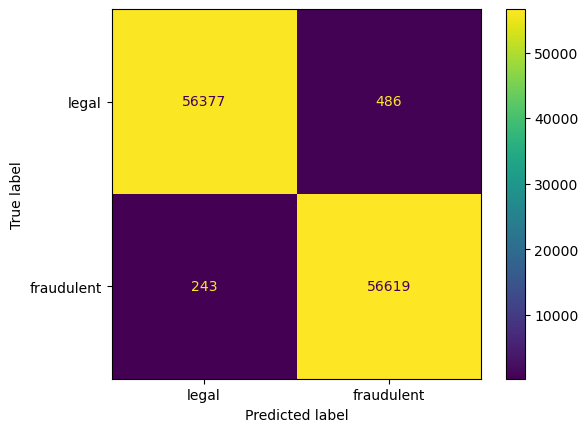




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9899583208764926, 0.9901517682851767, 0.9920071047957372, 0.9916290030424002, 0.9935897999560342]
Precision per round: 
[0.9899615509185337, 0.9901727468369381, 0.9920072911966737, 0.9916535756797318, 0.9935987960047198]
Recall per round: 
[0.9899583208764926, 0.9901517682851766, 0.9920071047957372, 0.9916290030424002, 0.993589818744137]
F1-score per round: 
[0.9899583043266741, 0.990151662912198, 0.9920071040386939, 0.9916288984463733, 0.9935897709296868]
AUC per round: 
[0.9899615509185337, 0.9901727468369381, 0.9920072911966737, 0.9916535756797317, 0.9935987960047198]
Fit_time per round: 
['19.66', '91.18', '13.78', '118.58', '14.6']
The average accuracy is:  0.9914671993911682
The average precision is:  0.9914787921273194
The average recall is:  0.9914672031487888
The average F1-score is:  0.9914671481307252
The average AUC is:  0.9914787921273194
The average fit-time is:  

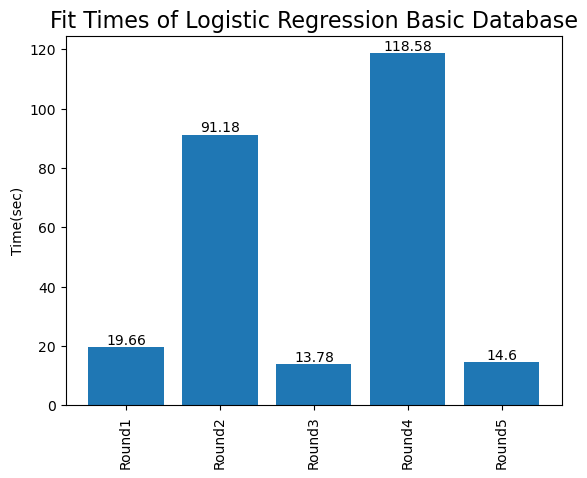



------------------------------------------------




In [41]:
target = df_zs_reduced['Class']
data = df_zs_reduced.drop('Class', axis = 1)
(nn_df_zs_red_acc_arr, nn_df_zs_red_acc, nn_df_zs_red_ft) = kfoldNeuralNetwork(target, data)

.

### Performance Evaluation of Neural Network Classifiers

As we observe from the statistics we obtained before, the NN Classifier we implemented had good results compared to the Logistic Regression ones. As expected, the classifiers obtained by Reduced Dataset had better performances in terms of fit-tie. Moreover, the classifier trained with Reduced Z-score scaled Dataset had better statistics in terms of accuracy and fit-time, as shown in the graphics above.

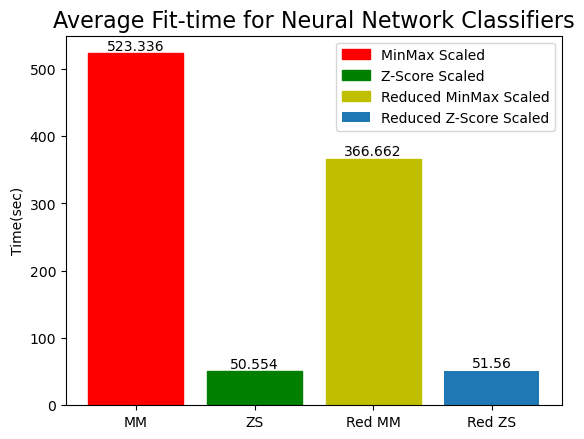

In [42]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3,4], [nn_df_mms_ft, nn_df_zs_ft, nn_df_mms_red_ft, nn_df_zs_red_ft], 
               label = ['MinMax Scaled', 'Z-Score Scaled', 'Reduced MinMax Scaled', 'Reduced Z-Score Scaled'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3,4],['MM', 'ZS', 'Red MM', 'Red ZS'])
plt.title('Average Fit-time for Neural Network Classifiers', fontsize = 16);
plt.ylabel('Time(sec)')
plt.show()

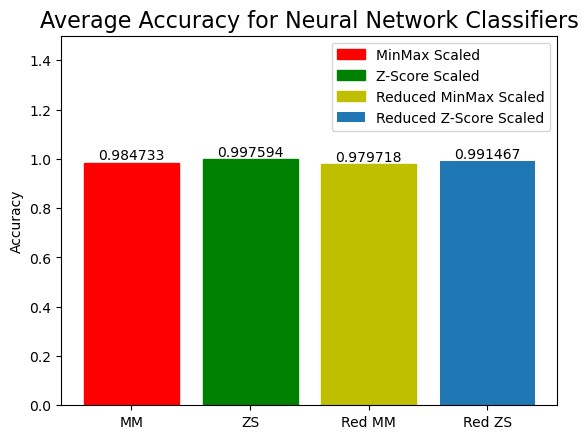

In [43]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3,4], [nn_df_mms_acc, nn_df_zs_acc, nn_df_mms_red_acc, nn_df_zs_red_acc], 
               label = ['MinMax Scaled', 'Z-Score Scaled', 'Reduced MinMax Scaled', 'Reduced Z-Score Scaled'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3,4],['MM', 'ZS', 'Red MM', 'Red ZS'])
plt.title('Average Accuracy for Neural Network Classifiers', fontsize = 16);
plt.ylabel('Accuracy')
plt.ylim((0, 1.5))
plt.show()

I performed a t-test between the classifier trained with the Reduced MinMax Scaled Dataset and the one trained with the Reduced Z-Score Scaled Dataset and I obtained that:

In [44]:
t_test("MinMax Scaled", nn_df_mms_red_acc_arr, "Z-Score Scaled", nn_df_zs_red_acc_arr, 0.05)

The Null Hypothesis is set at a confidence level of 5.0%
Distributions are statistically different in terms of accuracy. The best classifier is the Z-Score Scaled


.

---

## Random Forest

The last classifier I decided to test is the Random Forest classifier. It is based on a number of decision tree that predict the result class and the final decision is made by majority. The parameters I used for the classifier is a maximum depth of 20 and a random state equal to zero. The advantages of the Random Forest classifier are that it is one of the best classifiers available and that have good performance for large datasets.

The function I used for the implementation of the Random Forest classifier is the following, containing also operations to obtain the metrics considered during the work. 

In [45]:
def kfoldRandomForest(target, data):
    df_target = target
    df_data = data

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
    RF = RandomForestClassifier(max_depth = 20, random_state = 0)
    
    fit_time = []
    round_acc = []
    round_prec = []
    round_auc = []
    round_rec = []
    round_f1s = []
    
    k = 1
    for train, test in skf.split(np.zeros(len(df_target)), df_target):
        print(f'FOLD {k}')
        
        #Fit and predict using classifier
        X_tr = df_data.iloc[train]
        y_tr = df_target.iloc[train]
        X_te = df_data.iloc[test]
        y_te = df_target.iloc[test]
        
        
        start = time.time()
        RF.fit(X_tr,y_tr)
        end = time.time()
        
        fit_time.append(str(round(end-start, 2)))
        
        y_pred = RF.predict(X_te)
        
        round_auc.append(roc_auc_score(y_pred, y_te))
        
        print("--------------- CLASSIFICATION REPORT --------------\n")
        cr = classification_report(y_te, y_pred, output_dict = True)
        print(classification_report(y_te, y_pred))
        
        round_acc.append(cr['accuracy'])
        round_prec.append(cr['macro avg']['precision'])
        round_rec.append(cr['macro avg']['recall'])
        round_f1s.append(cr['macro avg']['f1-score'])
        round_auc.append(roc_auc_score(y_pred, y_te))
        
        print("--------------- CONFUSION MATRIX --------------\n")
        ConfusionMatrixDisplay.from_predictions(y_te, y_pred, display_labels = ['legal','fraudulent'])
        plt.show()

        k=k+1


    
    print("\n\n\n---------------------------------\n -------------- GENERAL STATISTICS ------------\n")
    print("Accuracy per round: ")
    print(round_acc)

    print("Precision per round: ")
    print(round_prec)

    print("Recall per round: ")
    print(round_rec)

    print("F1-score per round: ")
    print(round_f1s)

    print("AUC per round: ")
    print(round_auc)
    
    print("Fit_time per round: ")
    print(fit_time)

    avg_acc = np.mean(round_acc)
    print("The average accuracy is: ", avg_acc)

    avg_prec = np.mean(round_prec)
    print("The average precision is: ", avg_prec)

    avg_rec = np.mean(round_rec)
    print("The average recall is: ", avg_rec)

    avg_f1s = np.mean(round_f1s)
    print("The average F1-score is: ", avg_f1s)

    avg_auc = np.mean(round_auc)
    print("The average AUC is: ", avg_auc)
        
    fit_time = [float(i) for i in fit_time]
        
    avg_fit_time = np.mean(fit_time)
    print("The average fit-time is: ", avg_fit_time, "seconds\n\n")   

    rounds = ["Round1", "Round2", "Round3", "Round4", "Round5"]
    fig, ax = plt.subplots()
    plot = plt.bar(rounds, fit_time)
    ax.bar_label(plot)
    plt.xticks(np.arange(5), ['Round1', 'Round2', 'Round3', 'Round4', 'Round5'], rotation = 'vertical')
    plt.title('Fit Times of Logistic Regression Basic Database', fontsize = 16);
    plt.ylabel("Time(sec)")
    plt.show()

    print("\n\n------------------------------------------------\n\n")
    return (round_acc, avg_acc, avg_fit_time)

.

### Random Forest on MinMax Scaled Dataset

In [46]:
df_mms.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.705598,0.379766,0.488612,0.238820,0.482134,0.593994,0.084851,0.335668,0.499874,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.036402,0.049097,0.016128,0.058708,0.035418,0.072201,0.008082,0.008599,0.288439,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.699540,0.355683,0.484780,0.200568,0.462507,0.548371,0.082387,0.333674,0.250307,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.704236,0.378424,0.487649,0.239754,0.481844,0.593136,0.083454,0.335548,0.499381,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.710986,0.402541,0.491123,0.279959,0.501614,0.642577,0.087551,0.339190,0.749745,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


FOLD 1
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



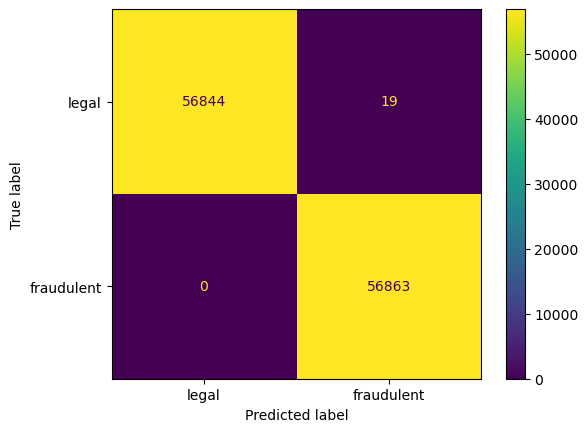

FOLD 2
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



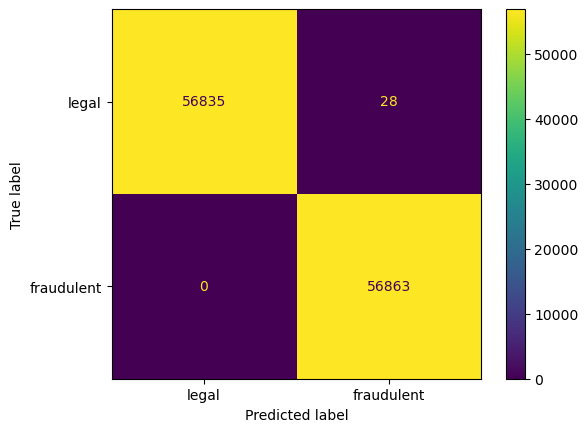

FOLD 3
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



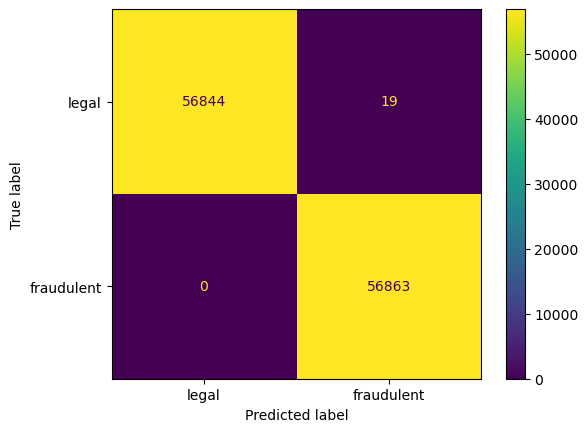

FOLD 4
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



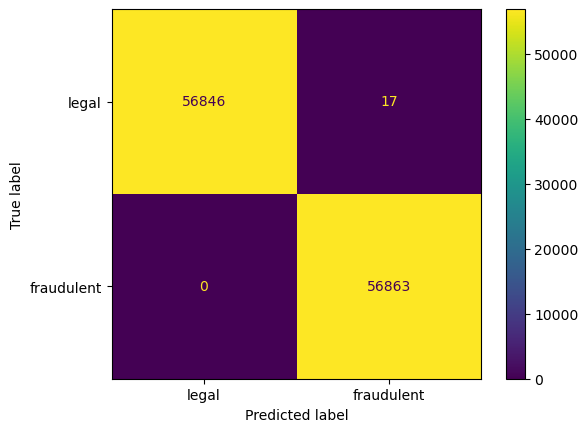

FOLD 5
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56862

    accuracy                           1.00    113725
   macro avg       1.00      1.00      1.00    113725
weighted avg       1.00      1.00      1.00    113725

--------------- CONFUSION MATRIX --------------



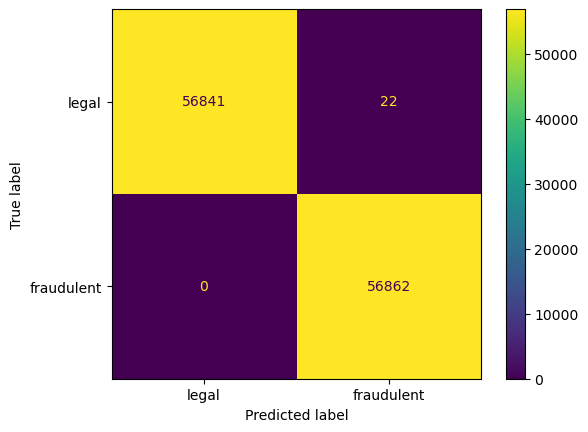




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9998329317834093, 0.9997537942071294, 0.9998329317834093, 0.9998505179114714, 0.9998065508903056]
Precision per round: 
[0.9998329875883407, 0.9997539153820464, 0.9998329875883407, 0.9998505625879044, 0.9998066240067506]
Recall per round: 
[0.9998329317834093, 0.9997537942071294, 0.9998329317834093, 0.9998505179114714, 0.999806552591316]
F1-score per round: 
[0.9998329317787461, 0.999753794192205, 0.9998329317787461, 0.9998505179081312, 0.9998065508837093]
AUC per round: 
[0.9998329875883407, 0.9998329875883407, 0.9997539153820464, 0.9997539153820464, 0.9998329875883407, 0.9998329875883407, 0.9998505625879044, 0.9998505625879044, 0.9998066240067506, 0.9998066240067506]
Fit_time per round: 
['354.77', '309.09', '310.16', '312.89', '301.62']
The average accuracy is:  0.9998153453151449
The average precision is:  0.9998154154306766
The average recall is:  0.9998153456553471
The av

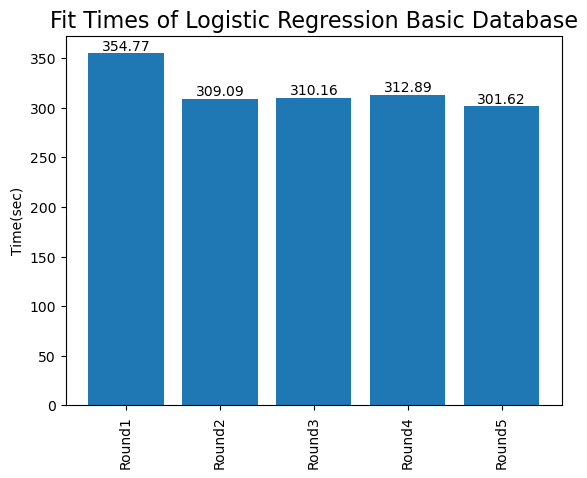



------------------------------------------------




In [47]:
target = df_mms['Class']
data = df_mms.drop('Class', axis = 1)
(rf_df_mms_acc_arr, rf_df_mms_acc, rf_df_mms_ft) = kfoldRandomForest(target, data)

.

### Random Forest on Z-score Scaled Dataset

In [48]:
df_zs.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-5.348167e-17,-5.223210e-18,1.028710e-17,-5.298184e-18,-6.847653e-18,1.524478e-17,8.397122e-18,-7.197533e-18,-1.422138e-16,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-1.938361e+01,-7.735086e+00,-3.029648e+01,-4.067970e+00,-1.361262e+01,-8.226963e+00,-1.049864e+01,-3.903536e+01,-1.733030e+00,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-1.664365e-01,-4.905153e-01,-2.376262e-01,-6.515818e-01,-5.541480e-01,-6.318948e-01,-3.049585e-01,-2.318753e-01,-8.652311e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,-3.741858e-02,-2.733978e-02,-5.968015e-02,1.590069e-02,-8.193326e-03,-1.189111e-02,-1.729089e-01,-1.392600e-02,-1.706617e-03,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,1.479986e-01,4.638922e-01,1.557313e-01,7.007386e-01,5.500151e-01,6.728875e-01,3.340244e-01,4.095939e-01,8.662877e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,8.087552e+00,1.263295e+01,3.170873e+01,1.296564e+01,1.462150e+01,5.623280e+00,1.132312e+02,7.725619e+01,1.733906e+00,1.000000


FOLD 1
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



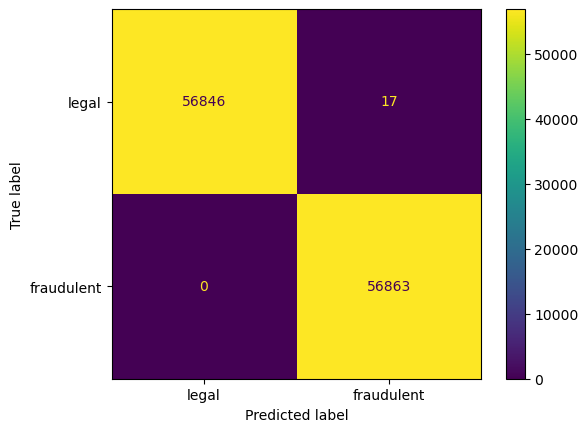

FOLD 2
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



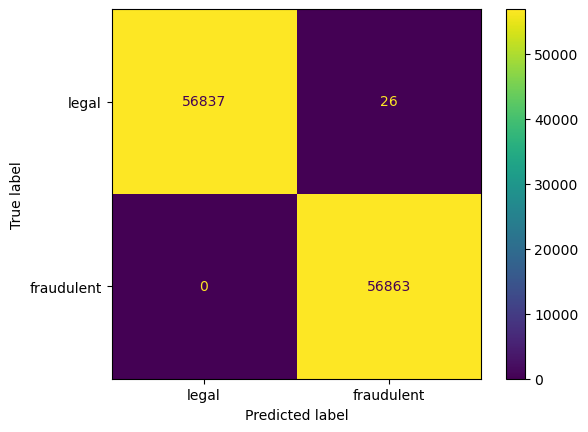

FOLD 3
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



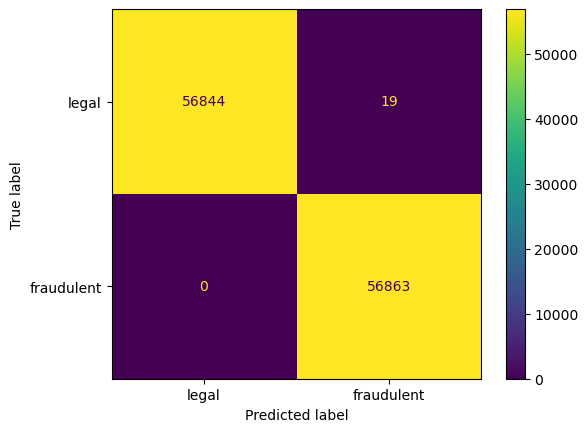

FOLD 4
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



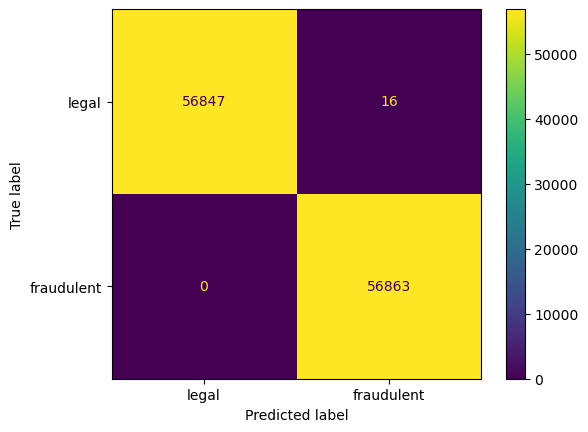

FOLD 5
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56862

    accuracy                           1.00    113725
   macro avg       1.00      1.00      1.00    113725
weighted avg       1.00      1.00      1.00    113725

--------------- CONFUSION MATRIX --------------



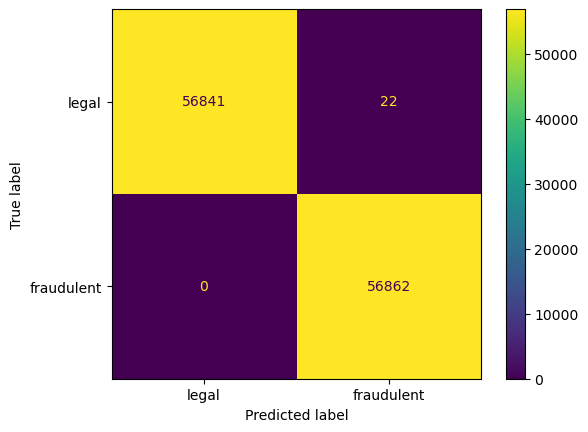




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9998505179114714, 0.9997713803351916, 0.9998329317834093, 0.9998593109755025, 0.9998065508903056]
Precision per round: 
[0.9998505625879044, 0.9997714848213187, 0.9998329875883407, 0.99985935055117, 0.9998066240067506]
Recall per round: 
[0.9998505179114714, 0.9997713803351915, 0.9998329317834093, 0.9998593109755025, 0.999806552591316]
F1-score per round: 
[0.9998505179081312, 0.9997713803232424, 0.9998329317787461, 0.9998593109727179, 0.9998065508837093]
AUC per round: 
[0.9998505625879044, 0.9998505625879044, 0.9997714848213187, 0.9997714848213187, 0.9998329875883407, 0.9998329875883407, 0.99985935055117, 0.99985935055117, 0.9998066240067506, 0.9998066240067506]
Fit_time per round: 
['383.16', '261.16', '421.91', '233.71', '420.83']
The average accuracy is:  0.9998241383791762
The average precision is:  0.999824201911097
The average recall is:  0.9998241387193781
The average 

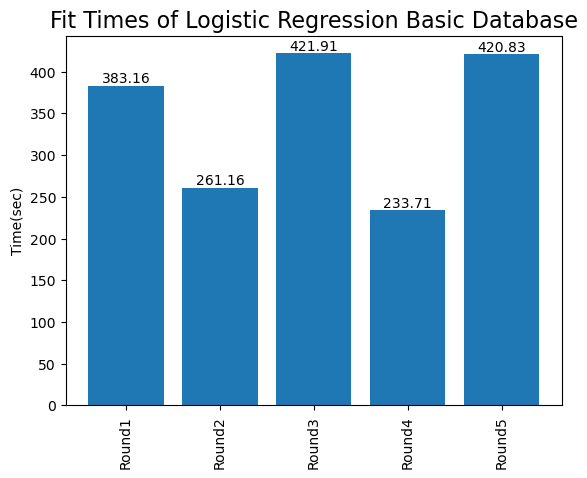



------------------------------------------------




In [49]:
target = df_zs['Class']
data = df_zs.drop('Class', axis = 1)
(rf_df_zs_acc_arr, rf_df_zs_acc, rf_df_zs_ft) = kfoldRandomForest(target, data)

.

### Random Forest on Reduced MinMax Scaled Dataset

In [50]:
df_mms_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,...,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000,568629.000000
mean,0.610622,0.919713,0.183931,0.607306,0.188966,0.446517,0.019583,0.643539,0.156187,0.090675,...,0.101355,0.099047,0.045317,0.262150,0.263093,0.670724,0.705598,0.084851,0.335668,0.499999
std,0.174684,0.018406,0.057771,0.122658,0.018986,0.021151,0.004500,0.059827,0.041629,0.028665,...,0.050166,0.046999,0.020464,0.105496,0.108629,0.085935,0.036402,0.008082,0.008599,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511876,0.910755,0.146420,0.526840,0.183394,0.437087,0.018307,0.632036,0.132511,0.073760,...,0.059660,0.058007,0.030660,0.196797,0.202692,0.622144,0.699540,0.082387,0.333674,0.000000
50%,0.594265,0.917212,0.183951,0.598259,0.190506,0.448182,0.020633,0.636686,0.160039,0.098203,...,0.109484,0.109880,0.048059,0.290807,0.272576,0.668492,0.704236,0.083454,0.335548,0.000000
75%,0.756074,0.926037,0.220242,0.694026,0.197315,0.457046,0.021950,0.646368,0.179468,0.107657,...,0.138712,0.134382,0.058733,0.316821,0.322230,0.718858,0.710986,0.087551,0.339190,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


FOLD 1
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



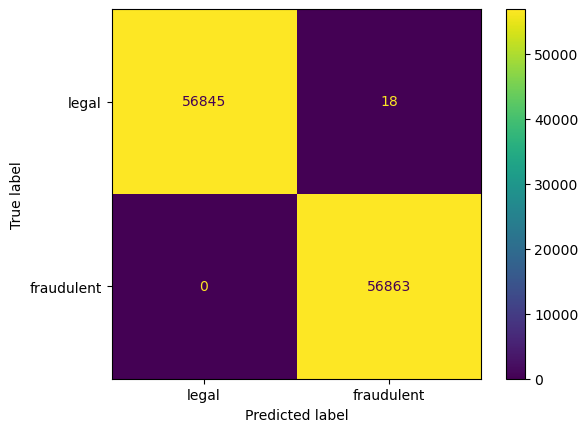

FOLD 2
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



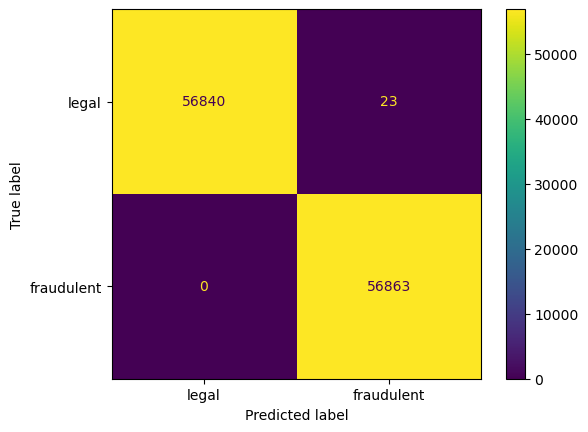

FOLD 3
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



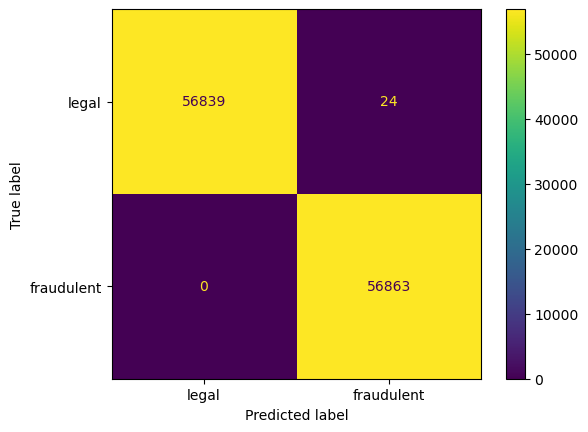

FOLD 4
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



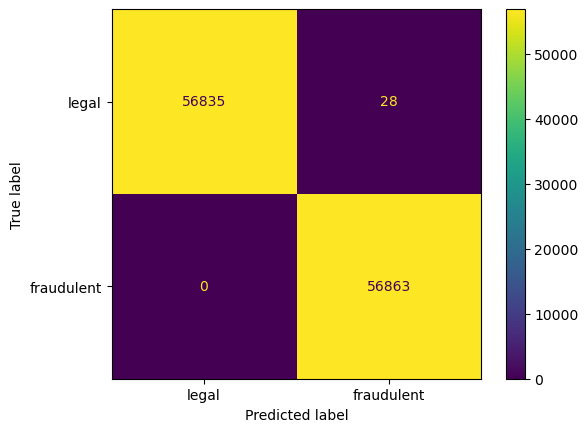

FOLD 5
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56862

    accuracy                           1.00    113725
   macro avg       1.00      1.00      1.00    113725
weighted avg       1.00      1.00      1.00    113725

--------------- CONFUSION MATRIX --------------



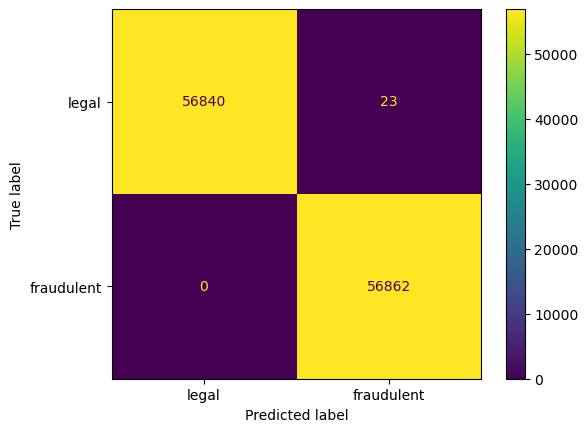




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9998417248474404, 0.9997977595272849, 0.9997889664632538, 0.9997537942071294, 0.9997977577489559]
Precision per round: 
[0.9998417749336334, 0.9997978412966284, 0.9997890554959833, 0.9997539153820464, 0.9997978377428145]
Recall per round: 
[0.9998417248474403, 0.9997977595272849, 0.9997889664632538, 0.9997537942071294, 0.9997977595272849]
F1-score per round: 
[0.9998417248434754, 0.9997977595190131, 0.9997889664538553, 0.999753794192205, 0.9997977577413873]
AUC per round: 
[0.9998417749336334, 0.9998417749336334, 0.9997978412966284, 0.9997978412966284, 0.9997890554959833, 0.9997890554959833, 0.9997539153820464, 0.9997539153820464, 0.9997978377428145, 0.9997978377428145]
Fit_time per round: 
['230.04', '253.16', '161.41', '254.84', '312.19']
The average accuracy is:  0.999796000558813
The average precision is:  0.9997960849702212
The average recall is:  0.9997960009144787
The av

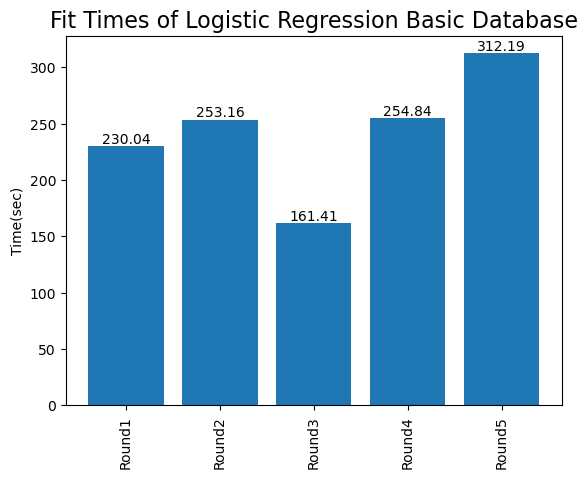



------------------------------------------------




In [51]:
target = df_mms_reduced['Class']
data = df_mms_reduced.drop('Class', axis = 1)
(rf_df_mms_red_acc_arr ,rf_df_mms_red_acc, rf_df_mms_red_ft) = kfoldRandomForest(target, data)

.

### Random Forest on Reduced Z-score Scaled Dataset

In [52]:
df_zs_reduced.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,V27,V28,Class
count,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,...,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,5.686290e+05,568629.000000
mean,4.798356e-18,4.958301e-17,2.087285e-16,5.997944e-17,-5.598081e-18,-2.759054e-17,7.597396e-17,-2.299212e-17,-3.038959e-17,-8.317150e-17,...,-2.007312e-16,6.077917e-17,-2.639096e-17,1.167600e-16,2.479150e-17,-9.976581e-17,-5.348167e-17,8.397122e-18,-7.197533e-18,0.499999
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.500000
min,-3.495592e+00,-4.996682e+01,-3.183764e+00,-4.951218e+00,-9.952786e+00,-2.111128e+01,-4.351860e+00,-1.075669e+01,-3.751915e+00,-3.163276e+00,...,-2.020400e+00,-2.107420e+00,-2.214516e+00,-2.484939e+00,-2.421950e+00,-7.804982e+00,-1.938361e+01,-1.049864e+01,-3.903536e+01,0.000000
25%,-5.652887e-01,-4.866777e-01,-6.493001e-01,-6.560194e-01,-2.934962e-01,-4.458696e-01,-2.835378e-01,-1.922738e-01,-5.687492e-01,-5.901016e-01,...,-8.311350e-01,-8.732063e-01,-7.162625e-01,-6.194854e-01,-5.560383e-01,-5.653081e-01,-1.664365e-01,-3.049585e-01,-2.318753e-01,0.000000
50%,-9.363905e-02,-1.358903e-01,3.523114e-04,-7.376305e-02,8.108730e-02,7.872271e-02,2.333636e-01,-1.145375e-01,9.252625e-02,2.626159e-01,...,1.620507e-01,2.304996e-01,1.340253e-01,2.716395e-01,8.729456e-02,-2.597802e-02,-3.741858e-02,-1.729089e-01,-1.392600e-02,0.000000
75%,8.326569e-01,3.435592e-01,6.285371e-01,7.070064e-01,4.397363e-01,4.977977e-01,5.259528e-01,4.728997e-02,5.592661e-01,5.924602e-01,...,7.446707e-01,7.518204e-01,6.556051e-01,5.182237e-01,5.443876e-01,5.601177e-01,1.479986e-01,3.340244e-01,4.095939e-01,1.000000
max,2.229047e+00,4.361892e+00,1.412584e+01,3.201534e+00,4.271689e+01,2.616862e+01,2.178739e+02,5.958215e+00,2.027005e+01,3.172269e+01,...,1.791355e+01,1.916955e+01,4.665293e+01,6.994120e+00,6.783714e+00,3.831668e+00,8.087552e+00,1.132312e+02,7.725619e+01,1.000000


FOLD 1
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



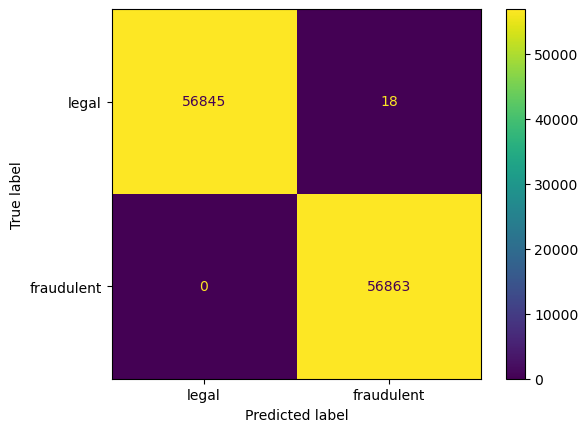

FOLD 2
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



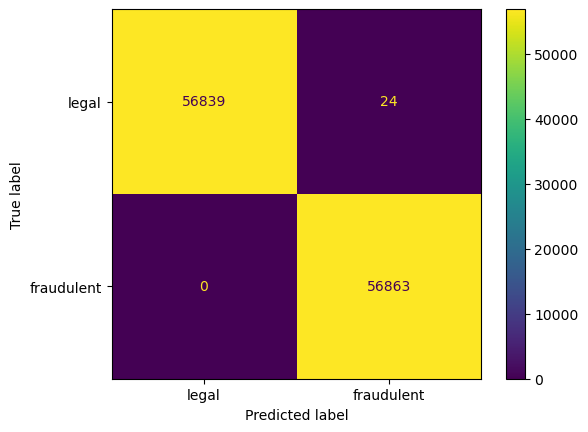

FOLD 3
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



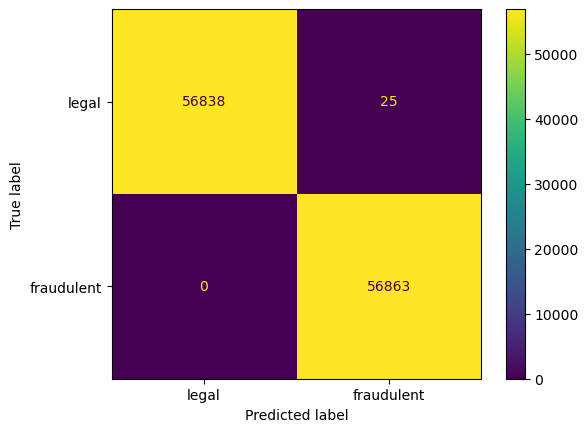

FOLD 4
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

--------------- CONFUSION MATRIX --------------



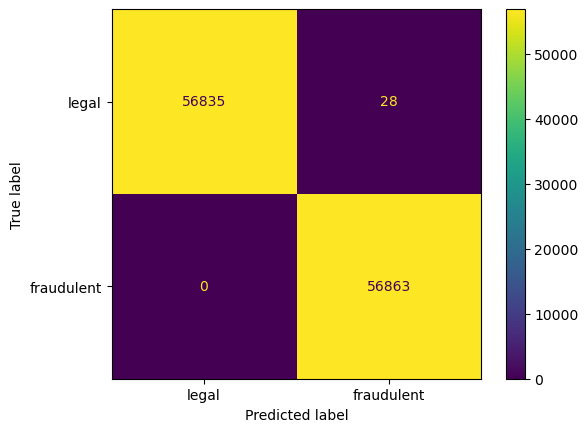

FOLD 5
--------------- CLASSIFICATION REPORT --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56862

    accuracy                           1.00    113725
   macro avg       1.00      1.00      1.00    113725
weighted avg       1.00      1.00      1.00    113725

--------------- CONFUSION MATRIX --------------



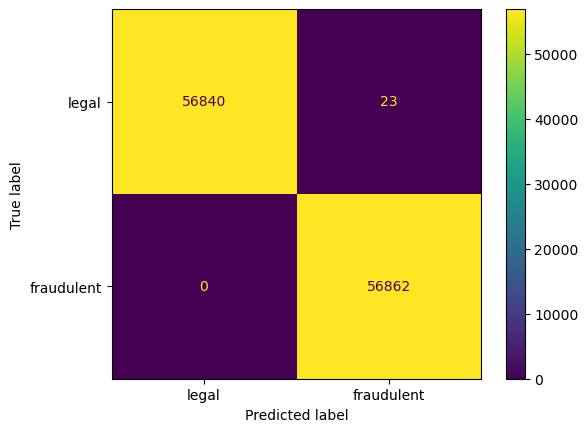




---------------------------------
 -------------- GENERAL STATISTICS ------------

Accuracy per round: 
[0.9998417248474404, 0.9997889664632538, 0.9997801733992226, 0.9997537942071294, 0.9997977577489559]
Precision per round: 
[0.9998417749336334, 0.9997890554959833, 0.9997802700042189, 0.9997539153820464, 0.9997978377428145]
Recall per round: 
[0.9998417248474403, 0.9997889664632538, 0.9997801733992226, 0.9997537942071294, 0.9997977595272849]
F1-score per round: 
[0.9998417248434754, 0.9997889664538553, 0.9997801733885998, 0.999753794192205, 0.9997977577413873]
AUC per round: 
[0.9998417749336334, 0.9998417749336334, 0.9997890554959833, 0.9997890554959833, 0.9997802700042189, 0.9997802700042189, 0.9997539153820464, 0.9997539153820464, 0.9997978377428145, 0.9997978377428145]
Fit_time per round: 
['209.1', '280.73', '252.2', '255.93', '256.37']
The average accuracy is:  0.9997924833332006
The average precision is:  0.9997925707117392
The average recall is:  0.9997924836888663
The ave

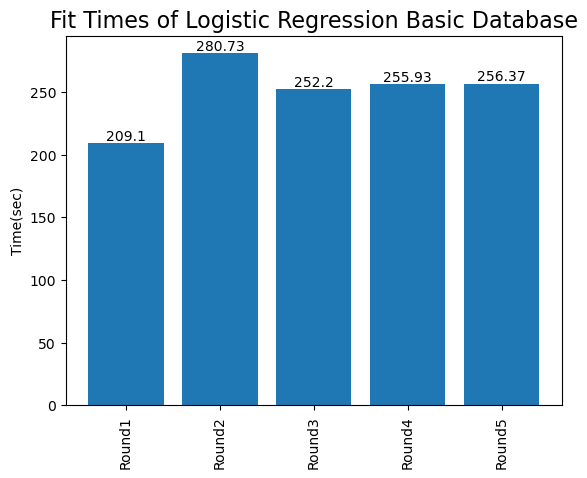



------------------------------------------------




In [53]:
target = df_zs_reduced['Class']
data = df_zs_reduced.drop('Class', axis = 1)
(rf_df_zs_red_acc_arr ,rf_df_zs_red_acc, rf_df_zs_red_ft) = kfoldRandomForest(target, data)


.

### Performance Evaluation of Random Forest Classifiers
The statistics obtained with the Random Forest Classifiers are the best compared with the Logistic Regression and with Neural Networks ones. The classifiers obtained by Reduced Dataset are better in terms of fit-time, as expected. The comparison between the classifers obtained are those below.

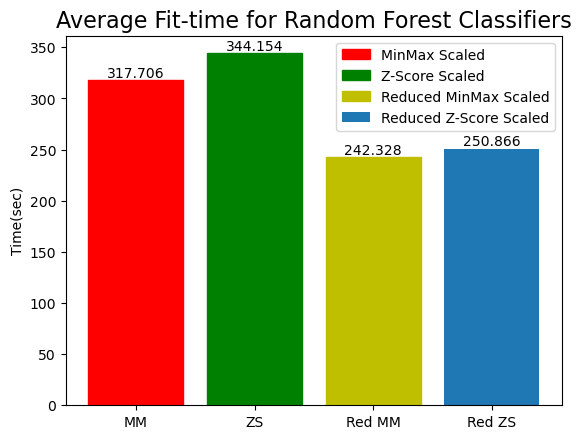

In [54]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3,4], [rf_df_mms_ft, rf_df_zs_ft, rf_df_mms_red_ft, rf_df_zs_red_ft], 
               label = ['MinMax Scaled', 'Z-Score Scaled', 'Reduced MinMax Scaled', 'Reduced Z-Score Scaled'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3,4],['MM', 'ZS', 'Red MM', 'Red ZS'])
plt.title('Average Fit-time for Random Forest Classifiers', fontsize = 16);
plt.ylabel('Time(sec)')
plt.show()

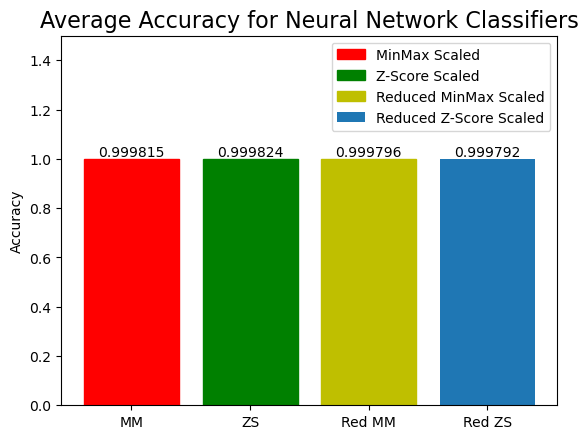

In [55]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3,4], [rf_df_mms_acc, rf_df_zs_acc, rf_df_mms_red_acc, rf_df_zs_red_acc], 
               label = ['MinMax Scaled', 'Z-Score Scaled', 'Reduced MinMax Scaled', 'Reduced Z-Score Scaled'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3,4],['MM', 'ZS', 'Red MM', 'Red ZS'])
plt.title('Average Accuracy for Neural Network Classifiers', fontsize = 16);
plt.ylabel('Accuracy')
plt.ylim((0, 1.5))
plt.show()

The t-test was performed with the two best classifiers in terms of statistics, that are those obtained by the training with the Reduced MinMax Scaled Dataset and with the Reduced Z-Score Scaled Dataset. What we obtained is:

In [56]:
t_test("MinMax Scaled", rf_df_mms_red_acc_arr, "Z-Score Scaled", rf_df_zs_red_acc_arr, 0.05)

The Null Hypothesis cannot be rejected
There is not statistically difference between the classifiers


---

## Global Performance Evaluation
In this last phase I compared the performance between the various kind of classifiers (Logistic Regression, Neural Network and Random Forest), using the best classifiers obtained on each phase. The graphs that summarize their statistics are shown below.

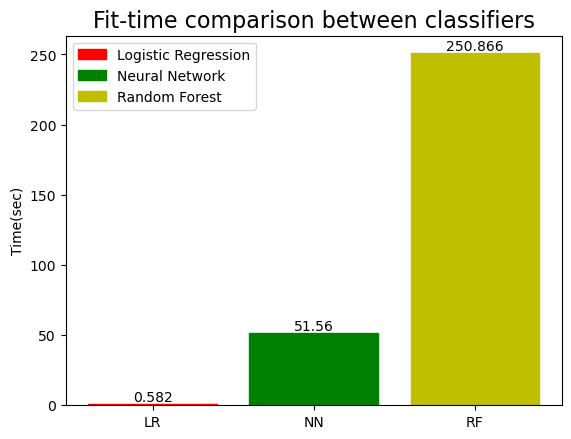

In [58]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3], [lr_df_zs_ft, nn_df_zs_red_ft, rf_df_zs_red_ft], 
               label = ['Logistic Regression', 'Neural Network', 'Random Forest'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3],['LR', 'NN', 'RF'])
plt.title('Fit-time comparison between classifiers', fontsize = 16);
plt.ylabel('Time(sec)')
plt.show()

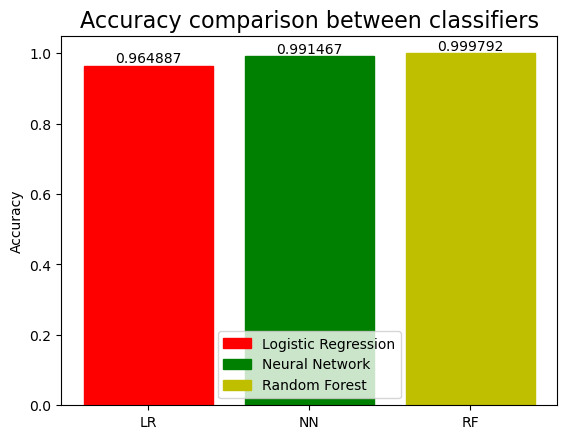

In [60]:
fig, ax = plt.subplots()
plot = plt.bar([1,2,3], [lr_df_zs_acc, nn_df_zs_red_acc, rf_df_zs_red_acc], 
               label = ['Logistic Regression', 'Neural Network', 'Random Forest'])
ax.bar_label(plot)
plot[0].set_color('r')
plot[1].set_color('g')
plot[2].set_color('y')
plt.legend(loc = 'best')
plt.xticks([1,2,3],['LR', 'NN', 'RF'])
plt.title('Accuracy comparison between classifiers', fontsize = 16);
plt.ylabel('Accuracy')
plt.show()

I performed the t-test between the two best classifiers, that are Neural Network Classifier and Random Forest Classifier, and I obtained that:

In [61]:
t_test("Nerual Network Classifier", nn_df_zs_red_acc_arr, "Random Forest Classifier", rf_df_zs_red_acc_arr, 0.05)

The Null Hypothesis is set at a confidence level of 5.0%
Distributions are statistically different in terms of accuracy. The best classifier is the Random Forest Classifier
